# Combining Learning and evolutionary Dynamics

This file contains the experiments for "Evolutionary multi-agent reinforcement learning in group social dilemmas" by Brian Mintz and Feng Fu, published as an editor's choice 2/12/2025 in Chaos: An Interdiscplinary Journal of Nonlinear Science. 

**Abstract**: Reinforcement learning (RL) is a powerful machine learning technique that has been successfully applied to a wide variety of problems. However, it can be unpredictable and produce suboptimal results in complicated learning environments. This is especially true when multiple agents learn simultaneously, which creates a complex system that is often analytically intractable. Our work considers the fundamental framework of Q-learning in public goods games, where RL individuals must work together to achieve a common goal. This setting allows us to study the tragedy of the commons and free-rider effects in artificial intelligence cooperation, an emerging field with potential to resolve challenging obstacles to the wider application of artificial intelligence. While this social dilemma has been mainly investigated through traditional and evolutionary game theory, our work connects these two approaches by studying agents with an intermediate level of intelligence. We consider the influence of learning parameters on cooperation levels in simulations and a limiting system of differential equations, as well as the effect of evolutionary pressures on exploration rate in both of these models. We find selection for higher and lower levels of exploration, as well as attracting values, and a condition that separates these in a restricted class of games. Our work enhances the theoretical understanding of recent techniques that combine evolutionary algorithms with Q-learning and extends our knowledge of the evolution of machine behavior in social dilemmas.


Motivation and gaps addressed:
1. Most of the MARL literature focuses on static groups, this evolutionary model incorporates dynamics groups, further destabilizing the learning environment. Similarly, many studies only consider a small number of agents, whereas this work considers larger groups, allowing for more complexity. 
2. This bridges the gap between traditional and evolutionary game theory by considering agents with intermediate complexity.

Research Question:
1. How does adding evolution change the dynamics, in particular, does it lead  to higher contribution? Can evolution solve this dilemma in learning agents?
2. How does the exploration rate evolve naturally? Are genetic algorithms a viable option for tuning this hyper-parameter for reinforcement learning in this application?ngs. 

# Model Simulation
The below code creates a class q_learner that follows a foundation reinforcement learning method. Using this, our main algorithm performes a Fisher process, a model for evolution that gives a genetic algorithm, with these agents and a general reward function / types of mutations. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
import copy

In [4]:
class q_learner:
    #q_values
    #age
    #fitness
    #discount_rate
    #learning_rate
    #temp
    #allele
        
    def __init__(self, parent, mut, q_values=-1, discount_rate=-1, learning_rate=-1, temp=-1, allele=-1):         
        self.age = 0
        self.fitness = 0
        
        if parent != None:
            q_vals = parent.q_values
            new_vals = np.zeros(np.shape(q_vals))
            for s in range(len(q_vals)):
                for a in range(len(q_vals[s])):
                    new_vals[s][a] = mut[0](q_vals[s][a]) 
            self.q_values = new_vals # note if parents q-values are huge, or tiny, this may not be super effective. 
            self.discount_rate = min(max(mut[1](parent.discount_rate), 0), 1)
            self.learning_rate = min(max(mut[2](parent.learning_rate), 0), 1)
            self.temp = mut[3](parent.temp) # somehow mutate one parent's function, change one of it's parameters, in own funct?
            self.allele = parent.allele # for tracking types in a population, so not helpful to mutate
        else:
            self.q_values = q_values
            self.discount_rate = discount_rate
            self.learning_rate = learning_rate
            self.temp = temp
            self.allele = allele

    def __str__(self):
        S = ""
        S += "q_values = " + str(self.q_values) + "\n"
        S += "discount_rate = " + str(self.discount_rate) + "\n"
        S += "learning_rate = " + str(self.learning_rate) + "\n"
        S += "temp(0) = " + str(self.temp(0)) + "\n"
        S += "allele = " + str(self.allele) + "\n"
        S += "age = " + str(self.age) + "\n"
        S += "fitness = " + str(self.fitness) + "\n\n"
        return S
    
    def choose_action(self, state):
        #m = np.mean(self.q_values[state]) # because probabilities are unchanged by subtracting a constant, and this
        #self.q_values[state] = [q-m for q in self.q_values[state]] # prevents overflow errors
        sorted = copy.deepcopy(self.q_values[state])
        sorted.sort()
        if (self.temp(self.age) == 0) or ((sorted[-1] - sorted[-2])/self.temp(self.age) > math.log(100)): # if the most likely action is more than 100 times as likely to be chosen as the next highest 
            choice = [np.argmax(self.q_values[state])] # just choose the highest. This introduces a small error, but solves overflow issues if q-values are [-10, 10]. 
        else:
            weights = np.array([math.exp(q/self.temp(self.age)) for q in self.q_values[state]])
            choice = np.random.choice(range(len(self.q_values[state])), 1, False, weights/sum(weights))
        return choice[0]  # since np.random.choice returns an array
    
    def update_vals(self, s, c, r, new_s):
        #q_values[g][c] = (1-learning_rate)*q_values[g][c] + learning_rate*(reward+discount_rate*max(q_values[g]))
        self.q_values[s][c] = self.q_values[s][c] + self.learning_rate*( 
            r+self.discount_rate*max(self.q_values[new_s])-self.q_values[s][c] ) # SHOULD BE NEXT STATE? PASS THIS IN TOO?
        self.age = self.age + 1
        self.fitness = (self.age*self.fitness+r)/(self.age+1) # average rewards
        #self.fitness = (self.fitness + r)/2 # a weighted average of rewards

def simple_mut(x):
    return lambda y: (1-x)*y+x*np.random.normal(0, 1) # or could omit the (1-x) in front of y. 

def temp_mut(x): # mutates the temperature at time zero according to x, returns the constant temperature function at this
    return lambda temp: lambda t: simple_mut(x)(temp(0))
    

# Basic Usage:
if False:
                    #parent, mutations, q_values,         discount_rate, learning_rate, temp,        allele
    bill = q_learner(None,   None,      [[0, 1], [0, 0]], 0.0,           0.5,           lambda t: 2, 1)
    jake = q_learner(bill,   [simple_mut(1), simple_mut(0.1), simple_mut(0), temp_mut(0)])
    
    print(jake)
    
    old_state = 1
    choice = bill.choose_action(old_state)
    print("bill chose " + str(choice) + " in state " + str(old_state))
    print(bill.age == 0) # should only increase when update_vals is called
    
    reward = 8
    new_state = 0
    bill.update_vals(old_state, choice, reward, new_state)
    print("New bill")
    print(bill)
    
    #reward_funct = lambda choices: [8*int(c == 1) for c in choices] # should be of state too
    reward_funct = lambda c: 1+int(c == 1)
    state = 1
    for i in range(100):
        choice = bill.choose_action(state)
        reward = reward_funct(choice)
        #print("[choice, reward] = " + str([choice, reward]))
        new_state = 1
        bill.update_vals(state, choice, reward, new_state)
        state = new_state
        
    print(bill)

In [5]:
def MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state):
    choices_hist = [-1]*n_iter
    agent_hist = [-1]*n_iter
    for i in range(n_iter):
        agent_hist[i] = [copy.deepcopy(a) for a in agents]
        group = random.sample(range(n_pop), n_group) # select a group from the population to play the game
        
        choices = [-1]*n_group                       # Each agent makes a choice of action
        for j in range(n_group):
            choices[j] = agents[group[j]].choose_action(state)
        choices_hist[i] = choices
        
        rewards = reward_funct(state, choices)              # The rewards and new state is determined, 
        new_state = update_state(state, choices)
        for j in range(n_group):
            agents[group[j]].update_vals(state, choices[j], rewards[j], new_state)
        state = new_state

        # each group member has probability replace_rate of being replaced, by another group member, according to their fitness
        for k in range(n_group):
            if random.random() < replace_rate: # with probability replace_rate, choose a random individual to replace
                dies   = k # np.random.choice(range(n_group), 1, False, [1/n_group]*n_group)[0] # use exp(reward) in case all = 0
                fitnesses = [math.exp(agents[group[j]].fitness) for j in range(n_group)]
                sum_fitness = sum(fitnesses)
                births = np.random.choice(range(n_group), 1, False, [f/sum_fitness for f in fitnesses])[0] # selection strength = 1
                agents[group[dies]] = q_learner(agents[group[births]], mutations) 
            
    return [choices_hist, agent_hist] # can get q_values and ages from this




# Basic use
n_pop = 10
n_group = 10
n_iter = 100
reward_funct = lambda state, choices: [1+int(c == 1) for c in choices]
replace_rate = 0.1
state = 0

q_val_MR = 0
DR_MR = 0
LR_MR = 0
temp_MR = 0
mutations = [simple_mut(q_val_MR), simple_mut(DR_MR), simple_mut(LR_MR), temp_mut(temp_MR)]
agents_1 = [q_learner(None, mutations, [[0, 0]],  0.0,           0.1,           lambda t: 2, "wild") for i in range(5)]
agents_2 = [q_learner(None, mutations, [[0, 0]],  0.0,           0.9,           lambda t: 2, "mtnt") for i in range(5)]
                                      # q_values, discount_rate, learning_rate, temp,        allele
agents = agents_1+agents_2

update_state = lambda state, choices: state


[choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)

print([q.q_values for q in agent_hist[-1]])
print([q.allele for q in agent_hist[-1]])

[array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]]), array([[1., 2.]])]
['mtnt', 'mtnt', 'mtnt', 'mtnt', 'mtnt', 'mtnt', 'mtnt', 'mtnt', 'mtnt', 'mtnt']


In this case, where the reward is highest for choosing action 1, we can see the mutants with a higher learning rate take over. Note there is no muation in this base simulation. 

## Learning Trajectories

This plots the strategy of each agent over time.

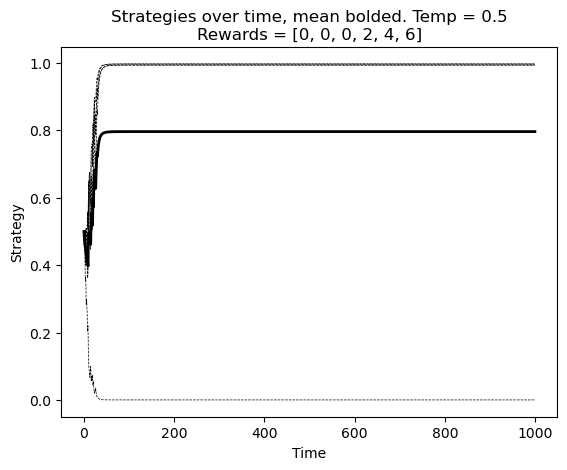

Simulation took 1.3551568984985352


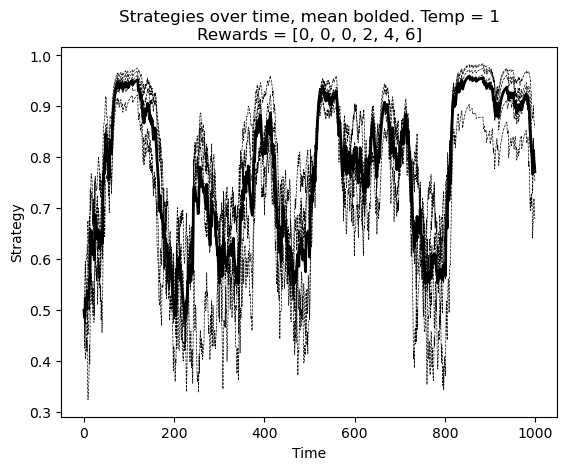

Simulation took 0.9272031784057617


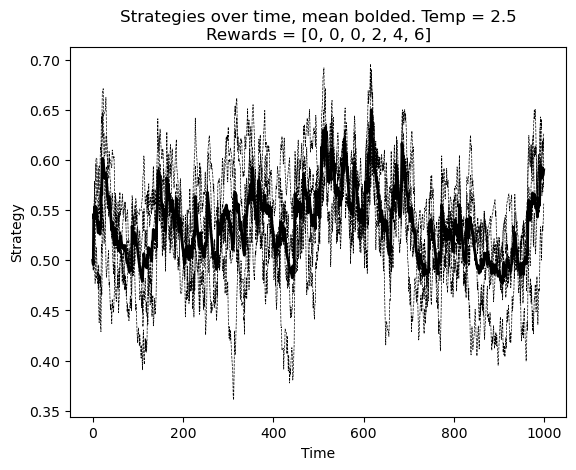

Simulation took 0.9934086799621582


In [7]:
def get_q_val_hist(agent_hist): # can similarly get age, or fitnesses. 
    n_iter = len(agent_hist)
    n_pop = len(agent_hist[0])
    q_val_hist = [[-1]*n_pop for i in range(n_iter)]
    for i in range(n_iter):
        for j in range(n_pop):
            q_val_hist[i][j] = agent_hist[i][j].q_values[0] # assumes only one state!
    return q_val_hist

def get_strats_over_time(agent_hist):
    n_iter = len(agent_hist)
    n_group = len(agent_hist[0])
    strat_hist = [0]*n_iter
    for i in range(n_iter):
        strats = [0]*n_group
        for j in range(n_group):
            q = agent_hist[i][j].q_values[0] # assumes only one state, 0. 
            T = agent_hist[i][j].temp(i) # their temperature at that time
            if T == 0:
                strats[j] = np.argmax(q)
            elif (q[1]-q[0])/T > 8:
                strats[j] =  1
            else:
                strats[j] = 1-1/(1+math.exp((q[1]-q[0])/T))
        strat_hist[i] = strats #np.mean(strats)
    return strat_hist

def plot_strats_over_time(strat_hist, title): # could do separate plots for q_1 and q_0, or plot their difference, or average them. 
    xs = range(n_iter) # recale by alpha/T to match ODE
    ys = strat_hist
    plt.plot(xs, ys, 'k--', linewidth=0.5)
    
    means = [np.mean(strats) for strats in strat_hist]
    plt.plot(xs, means, 'k', linewidth=2)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Strategy")
    plt.show()




n_pop = 5
n_group = n_pop
n_iter = 1000
actions = ["dog", "cat"] # [0, 1] meaningless to code
DR = 0 # gamma
LR = 0.1 # alpha, comes out in time scaling, 
state = 0
mutations = [simple_mut(0), simple_mut(0), simple_mut(0), temp_mut(0)]                                   
update_state = lambda state, choices: state
replace_rate = 0

def make_rewards(payoffs):
    return lambda state,choices: [payoffs[sum(choices)]-c for c in choices] # since contribution costs something

#rewards = [0,2,4,6,8,10] # always better to contribute
#rewards = [0,0,0,0,0,0] # never better to contribute
#rewards = [0,2,4,4,4,4] # stable at x=0.5
rewards = [0,0,0,2,4,6] # unstable at x=0.5

reward_funct = make_rewards(rewards)

temps = [0.5, 1, 2.5]
for i in range(len(temps)): # need to re-clear agents to remove q-values. 
    temp = lambda t: temps[i]
    agents = [q_learner(None, mutations, [[0, 0]], DR, LR,temp, "wild") for i in range(n_pop)]

    start = time.time()
    [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
    
    title = "Strategies over time, mean bolded. Temp = " + str(temp(0)) + "\nRewards = " + str(rewards) 
    plot_strats_over_time(get_strats_over_time(agent_hist), title) # assumes all agents have the same temp
    print("Simulation took " + str(time.time()-start))

This example uses a reward function from the public goods game, where a vector gives the reward depending on the number of contributing agents. Varying this changes the incentives for each player.  

A plot is made for each temperature shared by all agents in the population, representing a symmetric state where a single temperature has taken over the population. 

This next cell shows an interesting example where a reward function causes all agents to flip to pure cooperation. 

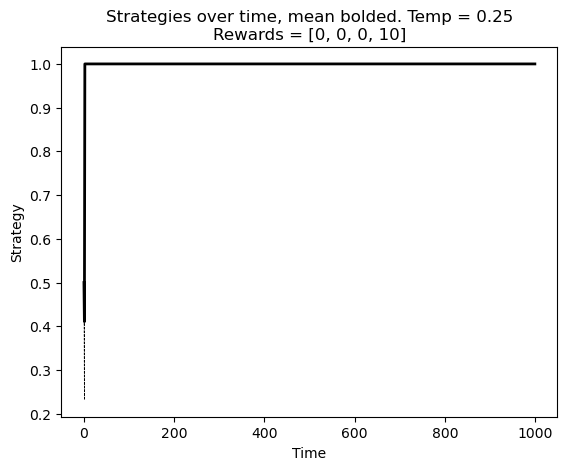

Simulation took 0.5219008922576904


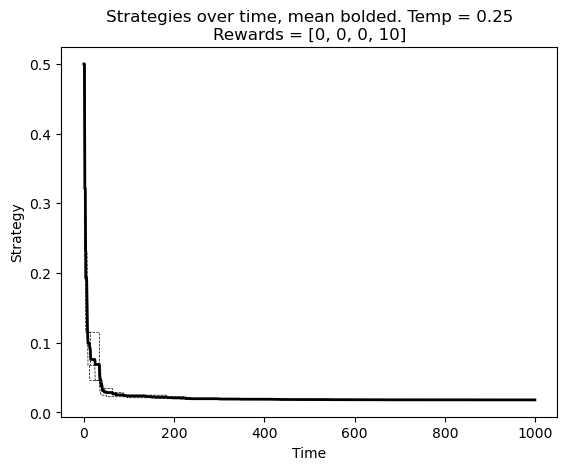

Simulation took 0.568413496017456


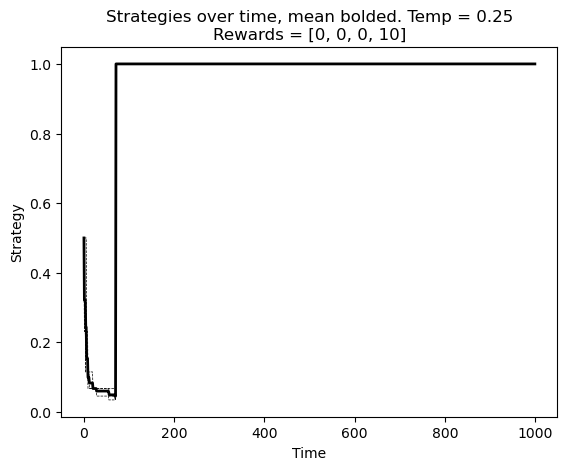

Simulation took 0.3416321277618408


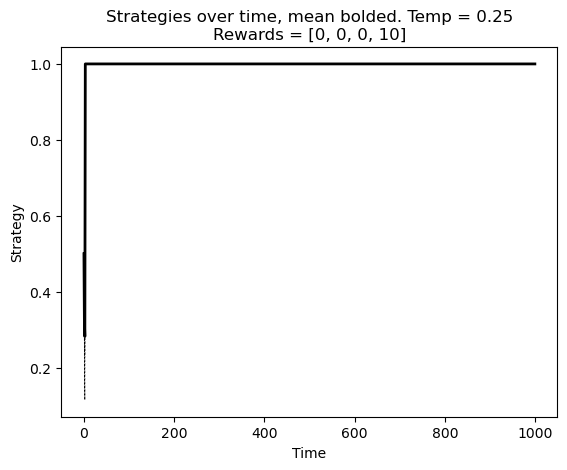

Simulation took 0.3026163578033447


In [12]:
n_iter = 1000
actions = ["Pig", "cat"] # [0, 1] meaningless to code
DR = 0 # gamma
LR = 0.3 # alpha, comes out in time scaling, 
state = 0
mutations = [simple_mut(0), simple_mut(0), simple_mut(0), temp_mut(0)]
update_state = lambda state, choices: state
replace_rate = 0

rewards = [0,0,0,10]
n_pop = len(rewards)-1
n_group = n_pop

reward_funct = make_rewards(rewards)

temps = [0.25]*4
for i in range(len(temps)): # need to re-clear agents to remove q-values. 
    temp = lambda t: temps[i]
    agents = [q_learner(None, mutations, [[0, 0]], DR, LR,temp, "wild") for i in range(n_pop)]

    start = time.time()
    [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
    
    title = "Strategies over time, mean bolded. Temp = " + str(temp(0)) + "\nRewards = " + str(rewards) 
    plot_strats_over_time(get_strats_over_time(agent_hist), title) # assumes all agents have the same temp
    print("Simulation took " + str(time.time()-start))

The learning dynamics favor not contributing, since it is unlikely to reach the necessary total contribution of 3 to receive the reward of 10. But once this is reached, it is large enough to flip everyone to contribution (everyone updates $q$-values since all were required to contribute to achieve this effect). 

This code also supports temperatures that vary in time, as in simulated annealing.  

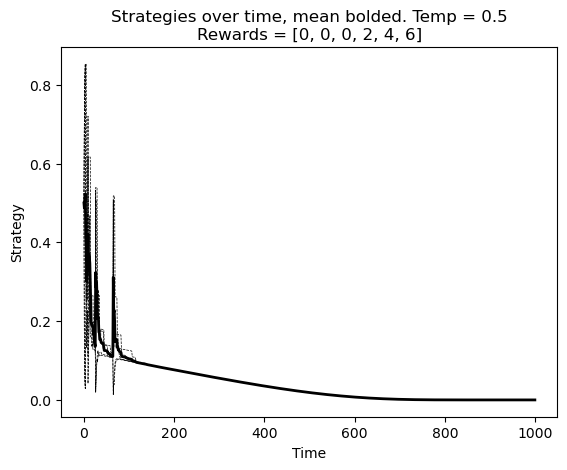

q_values = [[7.220777503460162e-276, -0.9999999924330041]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 0.5
allele = wild
age = 999
fitness = -0.02099999999999999


q_values = [[0.0, -0.9999999995186641]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 0.5
allele = wild
age = 999
fitness = -0.03400000000000001


q_values = [[5.379898476197808e-284, -0.9999999925280463]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 0.5
allele = wild
age = 999
fitness = -0.029000000000000047


q_values = [[3.463202926095505e-288, -0.9999999848514562]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 0.5
allele = wild
age = 999
fitness = -0.023999999999999973


q_values = [[5.776622003103698e-275, -0.9999999997125997]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 0.5
allele = wild
age = 999
fitness = -0.025999999999999985


Simulation took 0.8731606006622314


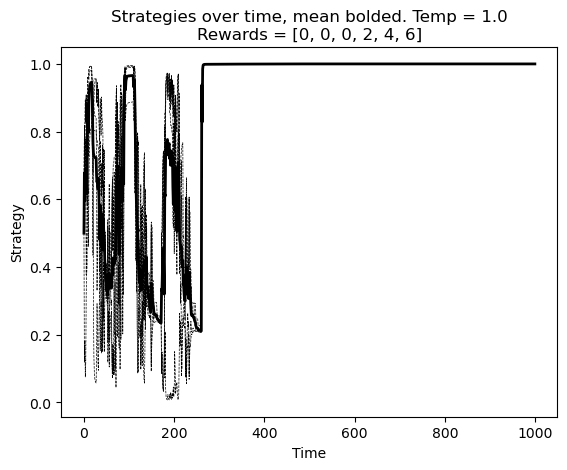

q_values = [[4.35750990847612e-10, 5.0]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 1.0
allele = wild
age = 999
fitness = 4.050999999999999


q_values = [[1.965182677073231e-19, 5.0]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 1.0
allele = wild
age = 999
fitness = 4.015999999999999


q_values = [[2.477398514111329e-07, 5.0]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 1.0
allele = wild
age = 999
fitness = 4.037000000000001


q_values = [[4.954979548244923e-07, 5.0]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 1.0
allele = wild
age = 999
fitness = 4.071000000000003


q_values = [[1.1963565610137022e-18, 5.0]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 1.0
allele = wild
age = 999
fitness = 4.018


Simulation took 0.649559736251831


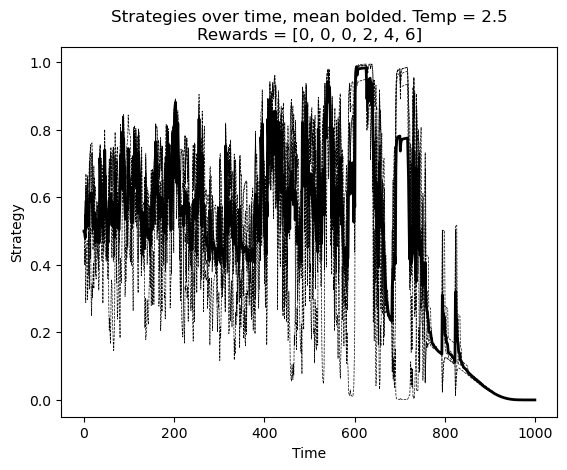

q_values = [[1.9128470611325123e-68, -0.9919425247009281]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 2.5
allele = wild
age = 999
fitness = 1.2889999999999995


q_values = [[9.956824449300434e-60, -0.9921860500398907]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 2.5
allele = wild
age = 999
fitness = 1.2639999999999998


q_values = [[9.468181182024444e-70, -0.9921260749069916]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 2.5
allele = wild
age = 999
fitness = 1.243000000000001


q_values = [[4.176194859519056e-53, -0.9687406958828433]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 2.5
allele = wild
age = 999
fitness = 1.291


q_values = [[1.6704779935917445e-52, -0.999966945033524]]
discount_rate = 0
learning_rate = 0.5
temp(0) = 2.5
allele = wild
age = 999
fitness = 1.2280000000000013


Simulation took 1.189051866531372


In [18]:
n_pop = 5
n_group = n_pop
n_iter = 1000
actions = ["dog", "cat"] # [0, 1] meaningless to code
DR = 0 
LR = 0.5
state = 0
mutations = [simple_mut(0), simple_mut(0), simple_mut(0), temp_mut(0)]
             # Q-vals ,     DR,            LR,            temp
agents = [q_learner(None, mutations, [[0, 0]], DR,            LR,            temp, "wild") for i in range(n_pop)]
                                   # q_values, discount_rate, learning_rate, temp, allele
update_state = lambda state, choices: state

replace_rate = 0

#rewards = [0,2,4,6,8,10] # always better to contribute
#rewards = [0,0,0,0,0,0] # never better to contribute
#rewards = [0,2,4,4,4,4] # stable at x=0.5
rewards = [0,0,0,2,4,6] # unstable at x=0.5

reward_funct = make_rewards(rewards)
temps = [0.5, 1, 2.5] # the base temperature, before mutations. 
for i in range(len(temps)): # need to re-clear agents to remove q-values. 
    temp = lambda t: temps[i]*(1-t/(n_iter+10))
    agents = [q_learner(None, mutations, [[0, 0]], DR, LR,temp, "wild") for i in range(n_pop)]

    start = time.time()
    [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
    
    title = "Strategies over time, mean bolded. Temp = " + str(temp(0)) + "\nRewards = " + str(rewards) 
    plot_strats_over_time(get_strats_over_time(agent_hist), title) # assumes all agents have the same temp
    for a in agent_hist[-1]:
        print(str(a))
    print("Simulation took " + str(time.time()-start))

Finally, here is an example of the code simulate the whole model including replacement and mutation.

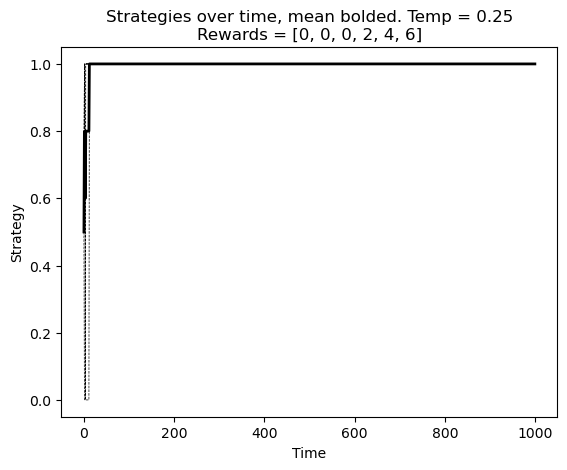

q_values = [[0. 5.]]
discount_rate = 0.0
learning_rate = 0
temp(0) = 0.25
allele = wild
age = 0
fitness = 0


q_values = [[0. 5.]]
discount_rate = 0.0
learning_rate = 0.06244549390410353
temp(0) = 0.25
allele = wild
age = 13
fitness = 4.642857142857143


q_values = [[0. 5.]]
discount_rate = 0.0
learning_rate = 0.0007447240741327646
temp(0) = 0.25
allele = wild
age = 2
fitness = 3.3333333333333335


q_values = [[0. 5.]]
discount_rate = 0.0
learning_rate = 0
temp(0) = 0.25
allele = wild
age = 20
fitness = 4.761904761904762


q_values = [[0. 5.]]
discount_rate = 0.0
learning_rate = 0
temp(0) = 0.25
allele = wild
age = 1
fitness = 2.5


Simulation took 2.6873743534088135


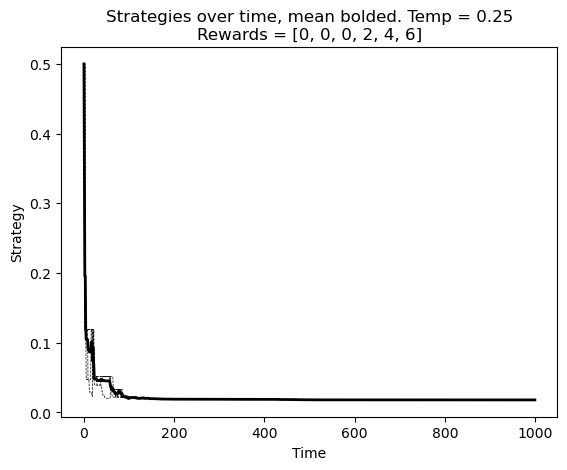

q_values = [[ 0.         -0.99989288]]
discount_rate = 0.0
learning_rate = 0.1342180719499557
temp(0) = 0.25
allele = wild
age = 24
fitness = 0.0


q_values = [[ 0.         -0.99989288]]
discount_rate = 0.0
learning_rate = 0.003298337011083563
temp(0) = 0.25
allele = wild
age = 3
fitness = 0.0


q_values = [[ 0.         -0.99989332]]
discount_rate = 0.0
learning_rate = 0.14023954221331456
temp(0) = 0.25
allele = wild
age = 1
fitness = 0.0


q_values = [[ 0.         -0.99989332]]
discount_rate = 0.0
learning_rate = 0.004178632115917284
temp(0) = 0.25
allele = wild
age = 13
fitness = -0.07142857142857142


q_values = [[ 0.         -0.99990204]]
discount_rate = 0.0
learning_rate = 0.21528006457169344
temp(0) = 0.25
allele = wild
age = 17
fitness = 0.0


Simulation took 4.212656021118164


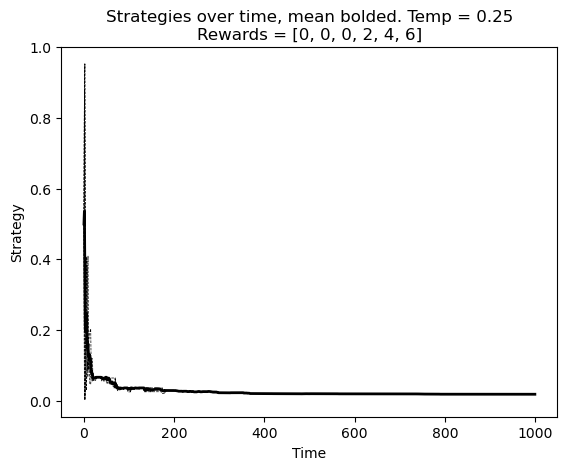

q_values = [[ 3.44527907e-69 -9.91806208e-01]]
discount_rate = 0.0
learning_rate = 0.011382477933830466
temp(0) = 0.25
allele = wild
age = 18
fitness = 0.0


q_values = [[ 6.70910701e-70 -9.92432500e-01]]
discount_rate = 0.0
learning_rate = 0.10101840876126414
temp(0) = 0.25
allele = wild
age = 5
fitness = 0.0


q_values = [[ 5.43825481e-70 -9.92432500e-01]]
discount_rate = 0.0
learning_rate = 0.1379950387399575
temp(0) = 0.25
allele = wild
age = 9
fitness = 0.0


q_values = [[ 9.96089822e-70 -9.92897957e-01]]
discount_rate = 0.0
learning_rate = 0.06150735018437307
temp(0) = 0.25
allele = wild
age = 5
fitness = -0.16666666666666666


q_values = [[ 1.52969156e-71 -9.94450260e-01]]
discount_rate = 0.0
learning_rate = 0.32808002518307366
temp(0) = 0.25
allele = wild
age = 7
fitness = -0.125


Simulation took 5.675095081329346


In [17]:
n_pop = 5
n_group = n_pop
n_iter = 1000
actions = ["dog", "cat"] # [0, 1] meaningless to code
DR = 0 
LR = 0.5
state = 0
mutations = [simple_mut(0), simple_mut(0), simple_mut(0.1), temp_mut(0)]
             # Q-vals ,     DR,            LR,            temp
agents = [q_learner(None, mutations, [[0, 0]], DR,            LR,            temp, "wild") for i in range(n_pop)]
                                   # q_values, discount_rate, learning_rate, temp, allele
update_state = lambda state, choices: state

#temp = lambda t: 5*(1-t/(n_iter+10))
#temp = lambda t: 0.5
replace_rate = 0.1

#rewards = [0,2,4,6,8,10] # always better to contribute
#rewards = [0,0,0,0,0,0] # never better to contribute
#rewards = [0,2,4,4,4,4] # stable at x=0.5
rewards = [0,0,0,2,4,6] # unstable at x=0.5

reward_funct = make_rewards(rewards)
temps = [0.25]*3 #, 0.5, 0.75, 1, 1.5, 2, 2.5, 3] # the base temperature, before mutations. 
for i in range(len(temps)): # need to re-clear agents to remove q-values. 
    temp = lambda t: temps[i]
    agents = [q_learner(None, mutations, [[0, 0]], DR, LR,temp, "wild") for i in range(n_pop)]

    start = time.time()
    [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
    
    title = "Strategies over time, mean bolded. Temp = " + str(temp(0)) + "\nRewards = " + str(rewards) 
    plot_strats_over_time(get_strats_over_time(agent_hist), title) # assumes all agents have the same temp
    for a in agent_hist[-1]:
        print(str(a))
    print("Simulation took " + str(time.time()-start))

## Effect of $T$ and $r$

A main research question is how does the learning, goverend by $T$, and evolution, governed by $r$, effect the level of cooperation? Do they alleviate it?

Here a small number of runs and iterations are used for speed, though in the paper larger values were used for more meaningful data. 

Done with 0 after 4.532889366149902
Done with 1 after 13.204989671707153
Done with 2 after 22.237391233444214
Done with 3 after 31.35418391227722
Simulation took 31.35418391227722


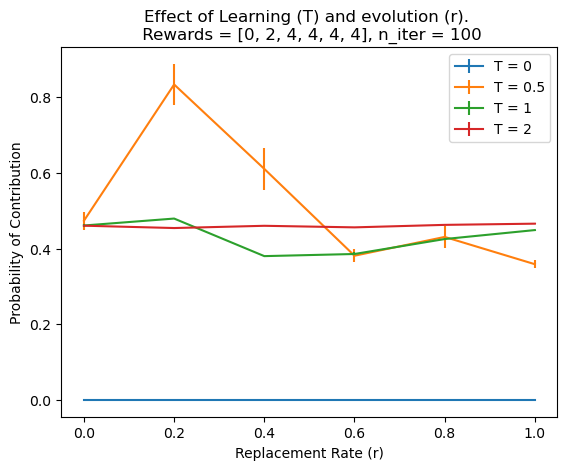

In [19]:
n_runs = 5
plotting = False

n_pop = 5
n_group = n_pop
n_iter = 100
actions = ["Pig", "cat"] # [0, 1] meaningless to code
DR = 0 # gamma
LR = 0.1 # alpha, comes out in time scaling, 
state = 0
mutations = [simple_mut(0), simple_mut(0), simple_mut(0), temp_mut(0)]
agents = [q_learner(None, mutations, [[0, 0]], DR,            LR,            temp, "wild") for i in range(n_pop)]
                                   # q_values, discount_rate, learning_rate, temp, allele
update_state = lambda state, choices: state

#rewards = [0,2,4,6,8,10] # always better to contribute
#rewards = [0,0,0,0,0,0] # never better to contribute
rewards = [0,2,4,4,4,4] # stable at x=0.5
#rewards = [0,0,0,2,4,6] # unstable at x=0.5

reward_funct = make_rewards(rewards)
temps = [0, 0.5, 1, 2]
rs = [0.2*i for i in range(6)]# [0, 0.25, 0.5, 0.75, 1]

means = [[0 for j in range(len(rs))] for i in range(len(temps))]
vars  = [[0 for j in range(len(rs))] for i in range(len(temps))]

start = time.time()
for i in range(len(temps)): # need to re-clear agents to remove q-values. 
    temp = lambda t: temps[i]
    for j in range(len(rs)): # need to re-clear agents to remove q-values. 
        replace_rate = rs[j]
        data = [-1]*n_runs
        for k in range(n_runs):
            agents = [q_learner(None, mutations, [[0, 0]], DR, LR,temp, "wild") for i in range(n_pop)]
        
            [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
            strat_hist = get_strats_over_time(agent_hist)
            data[k] = np.mean(strat_hist[-1]) # mean of average last strategy. 

            if plotting:
                title = "Strategies over time, mean bolded. Temp = " + str(temp(0)) + "\nRewards = " + str(rewards) + ", replacement = " + str(replace_rate) + "\n DR = " + str(DR) + ", LR = " + str(LR) 
                plot_strats_over_time(strat_hist, title) # assumes all agents have the same temp
            
        means[i][j] = np.mean(data) 
        vars[i][j]  = np.var(data)
    print("Done with " + str(i) + " after " + str(time.time()-start))
    
print("Simulation took " + str(time.time()-start))

for i in range(len(temps)):
    plt.errorbar(rs, means[i], yerr=vars[i])

plt.title("Effect of Learning (T) and evolution (r). \n Rewards = " + str(rewards) + ", n_iter = " + str(n_iter))
plt.xlabel("Replacement Rate (r)")
plt.ylabel("Probability of Contribution")
plt.legend(["T = " + str(t) for t in temps])
plt.show()

We can repeat the above, but fix $r$ or $T$ and plot the results for different games, highlighting the effect of these. 

Done with 0 after 2.4618079662323
Done with 1 after 4.815112590789795
Done with 2 after 7.504305124282837
Simulation took 7.504305124282837
[n_runs, n_iter, DR, LR, temp(0)] = [2, 100, 0, 0.1, 0.5]


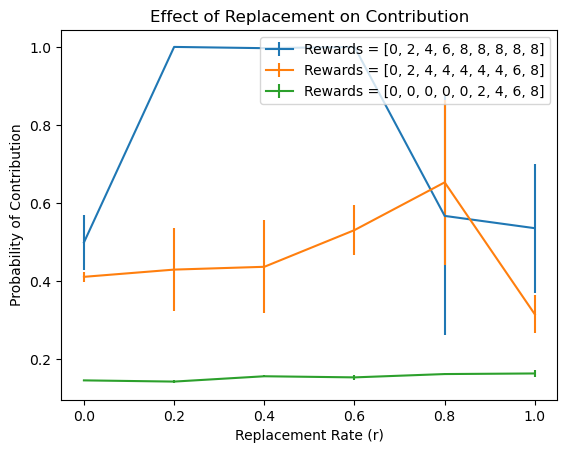

In [20]:
n_runs = 2
plotting = False

n_iter = 100
actions = ["Pig", "cat"] # [0, 1] meaningless to code
DR = 0 # gamma
LR = 0.1 # alpha, comes out in time scaling, 
state = 0
mutations = [simple_mut(0), simple_mut(0), simple_mut(0), temp_mut(0)]
agents = [q_learner(None, mutations, [[0, 0]], DR,            LR,            temp, "wild") for i in range(n_pop)]
                                   # q_values, discount_rate, learning_rate, temp, allele
update_state = lambda state, choices: state

#reward_list = [[0,0,0,10], [0, 0, 10, 10], [0, 10, 10, 10]]
reward_list = [[0,2,4,6,8,8,8,8,8], [0,2,4,4,4,4,4,6,8], [0,0,0,0,0,2,4,6,8]]

n_pop = len(rewards)-1
n_group = n_pop


temp = lambda t: 0.5
rs = [0.2*i for i in range(6)]

means = [[0 for j in range(len(rs))] for i in range(len(reward_list))]
vars  = [[0 for j in range(len(rs))] for i in range(len(reward_list))]

start = time.time()
for i in range(len(reward_list)): # need to re-clear agents to remove q-values. 
    reward_funct = make_rewards(reward_list[i])
    for j in range(len(rs)): # need to re-clear agents to remove q-values. 
        replace_rate = rs[j]
        data = [-1]*n_runs
        for k in range(n_runs):
            agents = [q_learner(None, mutations, [[0, 0]], DR, LR,temp, "wild") for i in range(n_pop)]
        
            [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
            strat_hist = get_strats_over_time(agent_hist)
            data[k] = np.mean(strat_hist[-1]) # mean of average last strategy. 

            if plotting:
                title = "Strategies over time, mean bolded. Temp = " + str(temp(0)) + "\nRewards = " + str(rewards) + ", replacement = " + str(replace_rate) + "\n DR = " + str(DR) + ", LR = " + str(LR) 
                plot_strats_over_time(strat_hist, title) # assumes all agents have the same temp
            
        means[i][j] = np.mean(data) 
        vars[i][j]  = np.var(data)
    print("Done with " + str(i) + " after " + str(time.time()-start))
    
print("Simulation took " + str(time.time()-start))


StdErr = [[(v[i]/n_runs)**0.5 for i in range(len(rs))] for v in vars]
for i in range(len(reward_list)):
    plt.errorbar(rs, means[i], yerr=StdErr[i])

print("[n_runs, n_iter, DR, LR, temp(0)] = " + str([n_runs, n_iter, DR, LR, temp(0)]))
plt.title("Effect of Replacement on Contribution")
plt.xlabel("Replacement Rate (r)")
plt.ylabel("Probability of Contribution")
plt.legend(["Rewards = " + str(rewards) for rewards in reward_list])
plt.show()

#file2write=open("filename",'w')
#file2write.write("here goes the data")
#file2write.close()

## Fixation probability

A key evolutionary metric is the probability that a single mutant can successfully invade, taking over a population (known as fixation). By calculating these, assuming mutations are sufficiently rare for one invasion to complete before the next begins, we can reduce to pairwise interactions of a wild and mutant type. This provides an overview of all possible evolutionary trajectories. 

The above simulation relax the assumption of low mutation rates, though lack these theoretical insights. 

In [21]:
def until_fixation(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state):
    agents = copy.deepcopy(agents)
    same_type = False
    deadman = 0
    while not(same_type) and (deadman < 100):
        [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
        agents = agent_hist[-1]
        same_type = (sum([agents[i].allele == agents[0].allele for i in range(n_pop)]) == n_pop) # true is 1, so all same if all are the first, 1+1+1+... n_pop times. 
        deadman = deadman+1
    winning_allele = agents[0].allele
    total_iter = deadman*n_iter
    return [winning_allele, total_iter]

def fixation_probability(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state, n_runs):
    i = 0
    win_sum = 0
    while i < n_runs:
        [winning_allele, deadman] = until_fixation(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
        win_sum = win_sum + winning_allele # assumes the alleles are 0 (wild) and 1 (mutatnt), then this approximates the probability of the mutant invading. 
        i = i + 1
    return win_sum / n_runs



n_pop = 10
n_group = 10
n_iter = 5
reward_funct = lambda state, choices: [1+int(c == 1) for c in choices]
replace_rate = 0.1
state = 0

q_val_MR = 0
DR_MR = 0
LR_MR = 0
temp_MR = 0
mutations = [simple_mut(q_val_MR), simple_mut(DR_MR), simple_mut(LR_MR), temp_mut(temp_MR)]
agents_1 = [q_learner(None, mutations, [[0, 0]],  0.0,           0.1,           lambda t: 0.5, 0) for i in range(5)]
#agents_2 = [q_learner(None, mutations, [[0, 0]],  0.0,           0.9,           lambda t: 0.5, 1) for i in range(5)]
agents_2 = [q_learner(None, mutations, [[0, 0]],  0.0,           0.1,           lambda t: 5, 1) for i in range(5)]
                                      # q_values, discount_rate, learning_rate, temp,        allele
agents = agents_1+agents_2

update_state = lambda state, choices: state

  
[winning_allele, total_iter] = until_fixation(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)

print("[winning_allele, total_iter] = " + str([winning_allele, total_iter]))



n_runs = 100
start = time.time()
fix_est = fixation_probability(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state, n_runs)
print("fix_est = " + str(fix_est))
print("Took " + str(time.time()-start))

[winning_allele, total_iter] = [0, 45]
fix_est = 0.23
Took 19.595892429351807


Under neutral selection, the fixation probability is the initial proportion. Comparing to this allows one to estimate if the selection is positive (or one could solve for the fixation probability assuming a constant selection strength, though this is unlikely).  

In [22]:
def get_fixations_heatplot_temp(xs, ys, LR, n_pop, n_group, n_iter, reward_funct, replace_rate, state, mutations, update_state, n_runs):
    table = [[0]*len(ys) for x in xs]
    for i in range(len(xs)):
        start_local = time.time()
        for j in range(len(ys)):
                                                # q_values, discount_rate, learning_rate, temp,        allele
            agents    = [q_learner(None, mutations, [[0, 0]],  0.0,           LR,         xs[i],   0) for k in range(n_pop)] # wild
            agents[0] =  q_learner(None, mutations, [[0, 0]],  0.0,           LR,         ys[j],   1) # mutant, can pass in a proportion
            
            #agents_1 = [q_learner(None, mutations, [[0, 0]],  0.0,           LR,           lambda t: xs[i],   0) for i in range(n_pop)] # wild
            #agents_2 = [q_learner(None, mutations, [[0, 0]],  0.0,           LR,           lambda t: ys[j],   1) for i in range(5)] # mutant
            #agents = agents_1+agents_2

            fix_est = fixation_probability(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state, n_runs)
            table[i][j] = fix_est-1/n_pop # to normalize, should really solve for selective advantage, p = (1-1/r)/(1-1/r^N)
        print("Iteration " + str(i) + " took " + str(time.time()-start_local))
    return np.transpose(np.asarray(table))

def make_heatplot(table, xs, ys, xlab, ylab, title):
    flip_table = np.flip(table,0) # since heatplot is weird
    fig, ax = plt.subplots()
    im = ax.imshow(flip_table, cmap = "Blues")

    # Add the color bar
    cbar = ax.figure.colorbar(im, ax = ax)
    cbar.ax.set_ylabel("Value", rotation = -90, va = "bottom")

    xlabels = [str(x) for x in xs]
    ax.set_xticks(range(len(xs)))
    ax.set_xticklabels(xlabels)
    ylabels = [str(y) for y in ys]
    ylabels.reverse()
    ax.set_yticks(range(len(ys)))
    ax.set_yticklabels(ylabels)

    plt.title(title)
    plt.xlabel(xlab) # check this by comparing a color and entry of the 2d array. 
    plt.ylabel(ylab)
    plt.show()

# could just pass in params_wild and params_mutant, probably easier. 

Iteration 0 took 1999.170794248581
Iteration 1 took 1601.9409358501434
Iteration 2 took 1336.3395812511444
Iteration 3 took 1255.917310476303
Iteration 4 took 1125.5941214561462
Iteration 5 took 1220.7229897975922
Iteration 6 took 1211.3349783420563
Iteration 7 took 2207.812306880951
Iteration 8 took 2080.687453508377
Iteration 9 took 12838.438328266144
Took 27366.22946214676
Iteration 0 took 2054.5373389720917
Iteration 1 took 1633.795449256897
Iteration 2 took 1462.9284136295319
Iteration 3 took 1285.2020971775055
Iteration 4 took 1221.1064848899841
Iteration 5 took 1070.687169790268
Iteration 6 took 1912.7300462722778
Iteration 7 took 2189.3340804576874
Iteration 8 took 4893.912575960159
Iteration 9 took 2318.5974032878876
Took 20043.076446056366


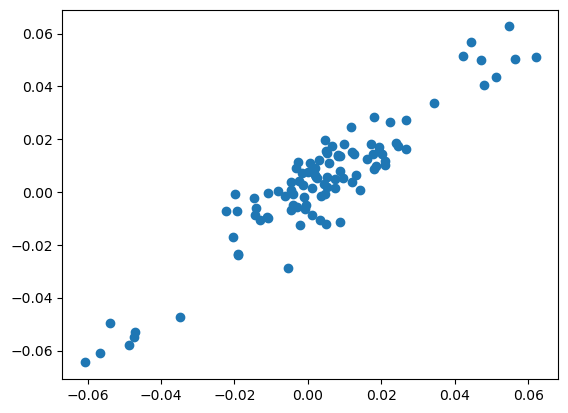

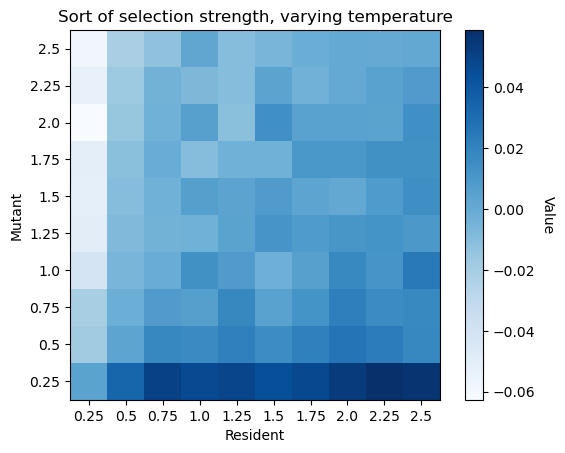

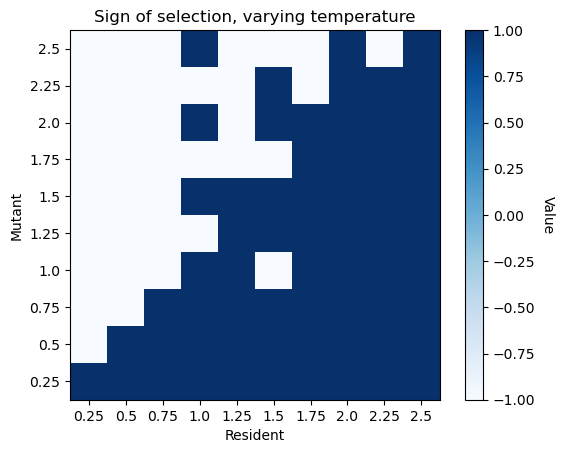

In [93]:
n_pop = 3
n_group = n_pop
n_iter = 5 # steps between checking if fixated. 
#reward_funct = lambda state, choices: [10*int(c == 1) for c in choices]

reward_funct = make_rewards([0,0,0,10])

replace_rate = 0.01 # small enough for the learning to occur (replacement happens late). 
state = 0
update_state = lambda state, choices: state

q_val_MR = 0
DR_MR = 0
LR_MR = 0
temp_MR = 0
mutations = [simple_mut(q_val_MR), simple_mut(DR_MR), simple_mut(LR_MR), temp_mut(temp_MR)]

n_runs = 5000

def make_const(height): # for some reason can't have lamnbdas in list comprehension
    return lambda t: height
    
xs = [make_const(i/4) for i in range(1,11)] # varying height now, now n_iter is different, and they may live longer than it. 
ys = [make_const(i/4) for i in range(1,11)] # technically should be zero, causes a divide by zero error. 0.01 is close enough for it to be similar
#xs = [make_sloped(i) for i in range(1,11)] # varying height now, now n_iter is different, and they may live longer than it. 
#ys = [make_sloped(i) for i in range(1,11)] # technically should be zero, causes a divide by zero error. 0.01 is close enough for it to be similar
#ys = np.linspace(0,1,3)[1:] # asymmetric, so know it works
LR = 0.5

start = time.time()
table = get_fixations_heatplot_temp(xs, ys, LR, n_pop, n_group, n_iter, reward_funct, replace_rate, state, mutations, update_state, n_runs)
print("Took " + str(time.time()-start))

def flatten(xss):
    return [x for xs in xss for x in xs]

start = time.time()
table2 = get_fixations_heatplot_temp(xs, ys, LR, n_pop, n_group, n_iter, reward_funct, replace_rate, state, mutations, update_state, n_runs)
print("Took " + str(time.time()-start))

plt.scatter(flatten(table), flatten(table2))
plt.show()
# if there is a correlation, that means these numbers are reliable.



avg_table = [[(table[i][j]+table2[i][j])/2 for j in range(len(table[0]))] for i in range(len(table))]
make_heatplot(avg_table, [x(0) for x in xs], [y(0) for y in ys], "Resident", "Mutant", "Sort of selection strength, varying temperature") # should add params
signs = [[math.copysign(1,avg_table[i][j]) for j in range(len(xs))] for i in range(len(ys))]
make_heatplot(signs, [x(0) for x in xs], [y(0) for y in ys], "Resident", "Mutant", "Sign of selection, varying temperature") # should add params

This could be extended to allow for evolution in the parameters. This may be rather unreliable given the randomness above. 

## Further explorations of the parameter space

Here we examine the strategies selected depending on two other important learning parameters: the discount and learning rates. These are not the main object of study in this work, but it is important context to understand their effect. 

In [23]:
def contrib_heatplot_vs_DR_and_LR(xs, ys, LR, n_pop, n_group, n_iter, reward_funct, replace_rate, state, mutations, update_state, n_runs, temp):
    means = [[0]*len(ys) for x in xs]
    StdErr = [[0]*len(ys) for x in xs]
    for i in range(len(xs)):
        start_local = time.time()
        for j in range(len(ys)):
            data = [0]*n_runs
            for k in range(n_runs):
                LR = xs[i]
                DR = ys[j]
                agents    = [q_learner(None, mutations, [[0, 0]],  DR, LR, temp,   0) for k in range(n_pop)]
                
                [choices_hist, agent_hist] = MARL_pop(n_pop, n_group, n_iter, reward_funct, replace_rate, state, agents, mutations, update_state)
                data[k] = get_strats_over_time(agent_hist[-2:])[-1] # get strategies at the end. 
            means[i][j] = np.mean(data)
            StdErr[i][j] = (np.var(data)/n_runs)**0.5
        print("Iteration " + str(i) + " took " + str(time.time()-start_local))
    return [means, StdErr]

0.5
Iteration 0 took 383.84027075767517
Iteration 1 took 358.75829672813416
Iteration 2 took 344.7670388221741
Iteration 3 took 333.1360137462616
Iteration 4 took 331.628436088562
Iteration 5 took 340.54318380355835
Iteration 6 took 322.04035902023315
Iteration 7 took 318.5879635810852
Iteration 8 took 317.10444712638855
Iteration 9 took 314.62672114372253
Took 3365.036657810211
Iteration 0 took 644.7977638244629
Iteration 1 took 822.8776018619537
Iteration 2 took 819.0890066623688
Iteration 3 took 800.8513035774231
Iteration 4 took 422.2984993457794
Iteration 5 took 332.1110694408417
Iteration 6 took 328.4654884338379
Iteration 7 took 326.9479088783264
Iteration 8 took 331.45704531669617
Iteration 9 took 323.11326241493225
Took 5152.03605723381


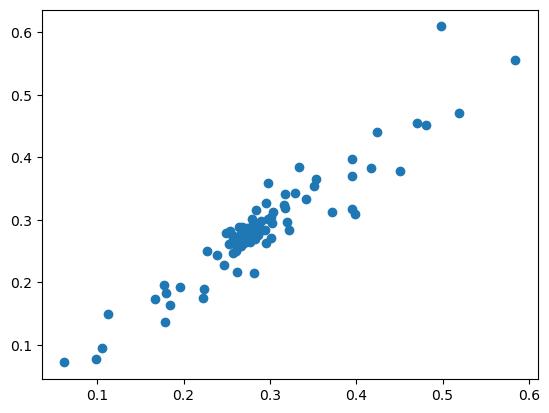

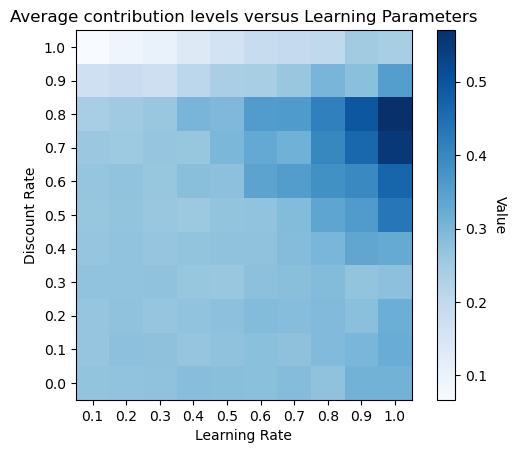

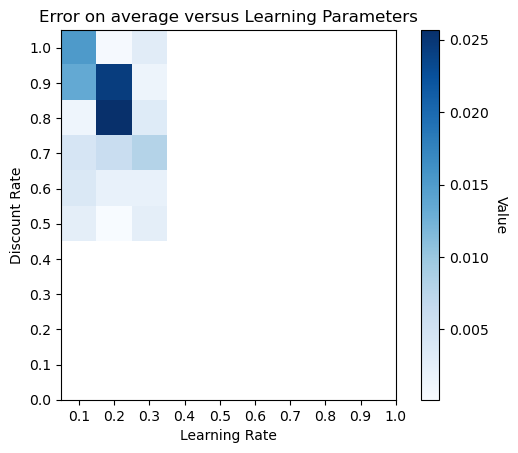

0.9
Iteration 0 took 289.7189404964447
Iteration 1 took 271.03886461257935
Iteration 2 took 251.36949515342712
Iteration 3 took 227.47665548324585
Iteration 4 took 210.48205542564392
Iteration 5 took 196.08144521713257
Iteration 6 took 175.13658499717712
Iteration 7 took 167.7295343875885
Iteration 8 took 162.49347448349
Iteration 9 took 146.57903385162354
Took 2098.123192548752
Iteration 0 took 256.865567445755
Iteration 1 took 259.07534646987915
Iteration 2 took 237.31926321983337
Iteration 3 took 31007.197172403336
Iteration 4 took 198.624436378479
Iteration 5 took 184.52178287506104
Iteration 6 took 169.44419479370117
Iteration 7 took 162.04542565345764
Iteration 8 took 153.80031657218933
Iteration 9 took 154.307541847229
Took 32783.21112895012


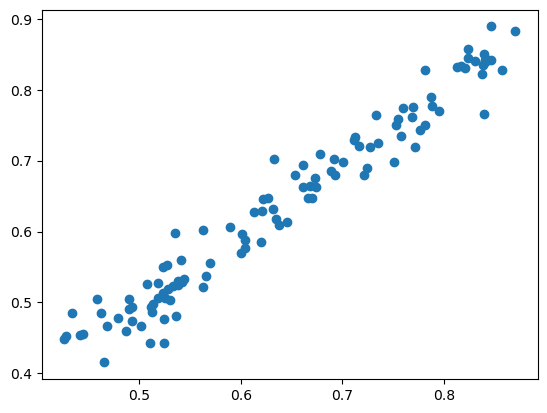

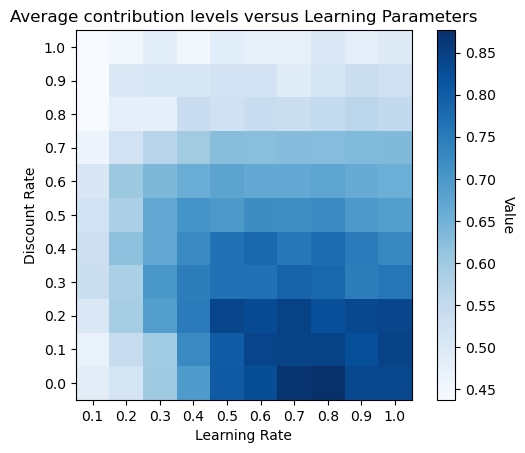

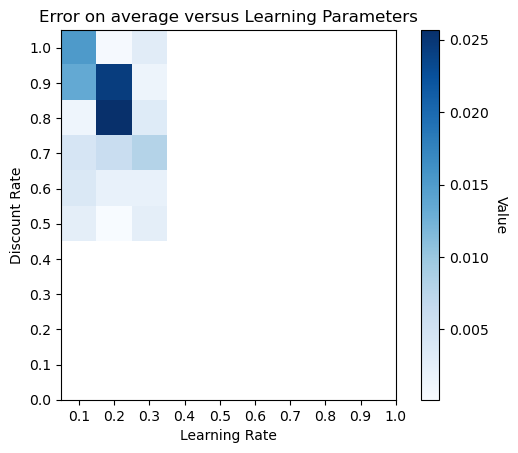

1.1
Iteration 0 took 225.58438849449158
Iteration 1 took 203.94706058502197
Iteration 2 took 190.54074335098267
Iteration 3 took 180.75512409210205
Iteration 4 took 167.2879798412323
Iteration 5 took 160.6874237060547
Iteration 6 took 151.15720009803772
Iteration 7 took 146.72928023338318
Iteration 8 took 143.86095571517944
Iteration 9 took 142.17936778068542
Took 1712.7354323863983
Iteration 0 took 220.7007303237915
Iteration 1 took 206.4965136051178
Iteration 2 took 184.37961339950562
Iteration 3 took 169.48672008514404
Iteration 4 took 169.07576990127563
Iteration 5 took 153.68314218521118
Iteration 6 took 150.35093116760254
Iteration 7 took 148.8564920425415
Iteration 8 took 145.91879963874817
Iteration 9 took 146.57179069519043
Took 1695.535838842392


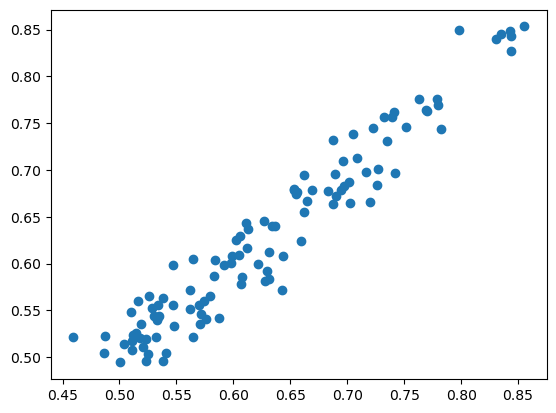

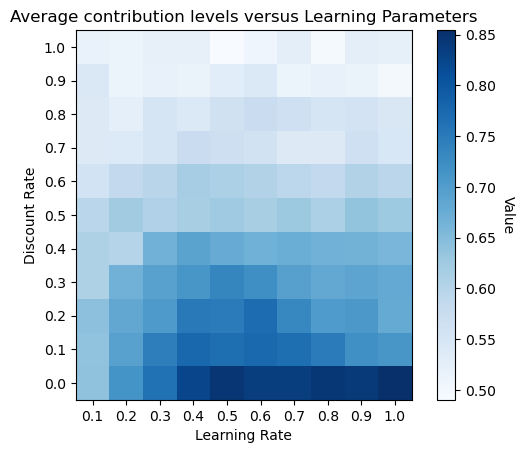

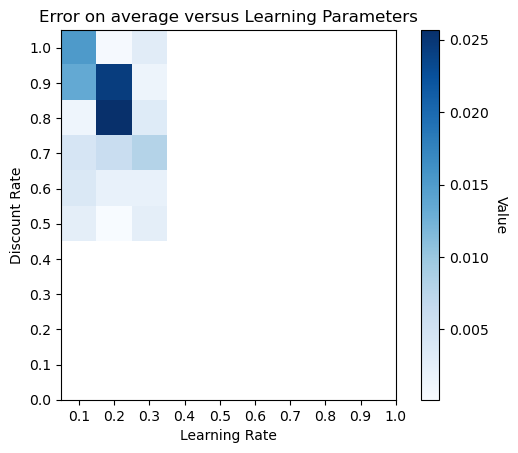

1.5
Iteration 0 took 172.11048936843872
Iteration 1 took 158.3388957977295
Iteration 2 took 152.6305115222931
Iteration 3 took 158.7959234714508
Iteration 4 took 143.42246437072754
Iteration 5 took 146.2428789138794
Iteration 6 took 143.83125185966492
Iteration 7 took 138.15423011779785
Iteration 8 took 131.77961134910583
Iteration 9 took 133.27741813659668
Took 1478.5928721427917
Iteration 0 took 157.33782839775085
Iteration 1 took 151.06542110443115
Iteration 2 took 139.24543738365173
Iteration 3 took 142.68714880943298
Iteration 4 took 133.32774901390076
Iteration 5 took 135.08873748779297
Iteration 6 took 133.38191318511963
Iteration 7 took 131.62200617790222
Iteration 8 took 132.1452178955078
Iteration 9 took 133.139484167099
Took 1389.0538370609283


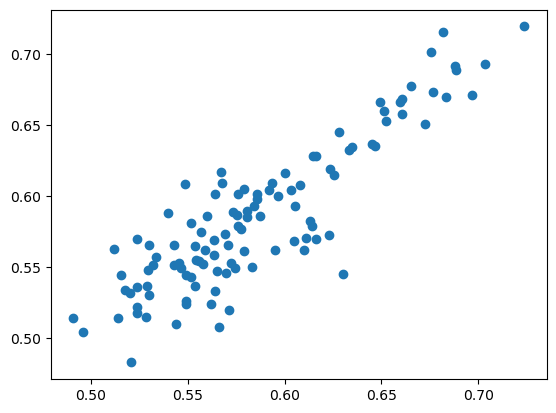

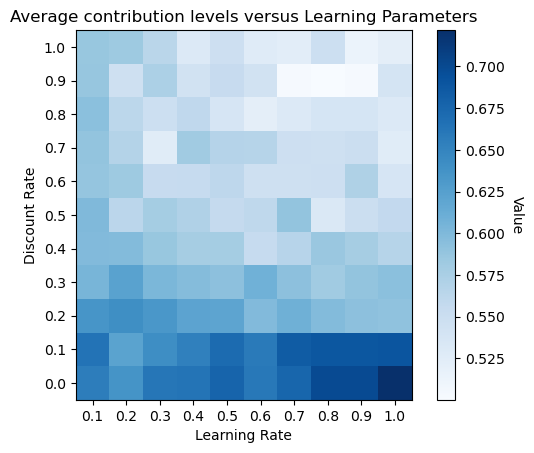

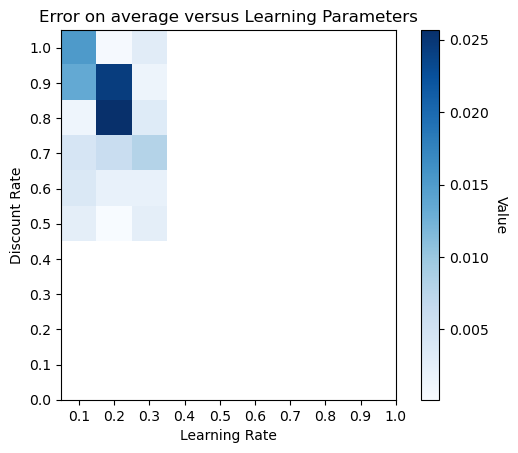

2
Iteration 0 took 135.1028606891632
Iteration 1 took 128.13296270370483
Iteration 2 took 128.6775004863739
Iteration 3 took 126.88949060440063
Iteration 4 took 126.67096638679504
Iteration 5 took 123.89159345626831
Iteration 6 took 125.81255555152893
Iteration 7 took 122.34682440757751
Iteration 8 took 125.7178943157196
Iteration 9 took 120.82374358177185
Took 1264.0689687728882
Iteration 0 took 134.09347009658813
Iteration 1 took 123.34433031082153
Iteration 2 took 119.39341473579407
Iteration 3 took 121.18301939964294
Iteration 4 took 115.48440623283386
Iteration 5 took 116.36974906921387
Iteration 6 took 119.20113396644592
Iteration 7 took 119.30894756317139
Iteration 8 took 119.44796919822693
Iteration 9 took 117.40000247955322
Took 1205.2429962158203


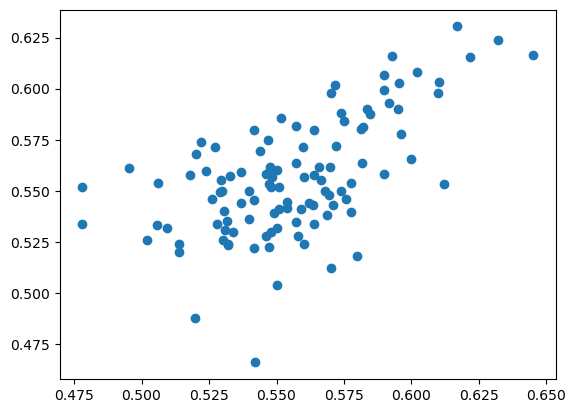

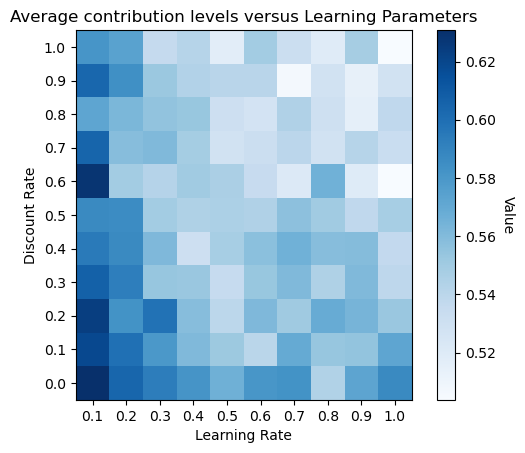

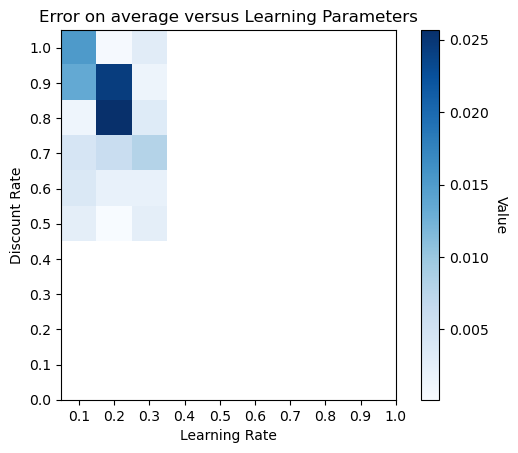

In [285]:
n_iter = 500 # steps between checking if fixated. 
replace_rate = 0
state = 0
update_state = lambda state, choices: state

mutations = [simple_mut(0), simple_mut(0), simple_mut(0), temp_mut(0)]

n_runs = 100
temp = lambda t: 0.5

grain = 10
xs = [i/grain for i in range(1,grain+1)] 
ys = [i/grain for i in range(grain+1)] 

ms = [0.5, 0.9, 1.1, 1.5, 2]
for m in ms:
    print(m)
    reward_funct = make_rewards([m*i for i in range(6)])
    n_pop = len(rewards)-1
    n_group = n_pop
    start = time.time()
    [means1, StdErr1] = contrib_heatplot_vs_DR_and_LR(xs, ys, LR, n_pop, n_group, n_iter, reward_funct, replace_rate, state, mutations, update_state, n_runs, temp)
    print("Took " + str(time.time()-start))
    
    start = time.time()
    [means2, StdErr2] = contrib_heatplot_vs_DR_and_LR(xs, ys, LR, n_pop, n_group, n_iter, reward_funct, replace_rate, state, mutations, update_state, n_runs, temp)
    means2_T = np.transpose(np.asarray(means2))
    print("Took " + str(time.time()-start))
    
    def flatten(xss):
        return [x for xs in xss for x in xs]
    
    plt.scatter(flatten(means1), flatten(means2))
    plt.show()
    # if there is a correlation, that means these numbers are reliable.
    
    avg_table = [[(means1[i][j]+means2[i][j])/2 for j in range(len(means1[0]))] for i in range(len(means1))]
    avg_table = np.transpose(np.asarray(avg_table))
    make_heatplot(avg_table, [x for x in xs], [y for y in ys], "Learning Rate", "Discount Rate", "Average contribution levels versus Learning Parameters")
    make_heatplot(np.transpose(np.asarray(StdErr1)), [x for x in xs], [y for y in ys], "Learning Rate", "Discount Rate", "Error on average versus Learning Parameters")

# ODE System

To avoid the complexity of these stochastic dynamics, we use a system of ODEs based on the work of Kianercy and Galstyan in "Dynamics of Boltzmann Q learning in two-player two-action games." They derive that the update rule for q-values of a single agent $$Q_i(t+1) = Q_i(t)+\alpha(r_i(t)-Q_i(t))$$ where $r_i(t)$ is the (expected) reward for choosing action $i$ at time $t$, leads to the differential equation $$\frac{\dot{x}_i}{x_i} = \left[r_i - \sum_{k=1}^n x_k r_k\right] - T \sum_{k=1}^n x_k \ln \frac{x_i}{x_k}$$ where $x_i$ is the probability of choosing action $i$, and $T$ is the temperature controling exploration of the agent. This is essentially the replicator mutator equations, where the first term is selection, and the second is mutation. Thus, within an agent, evolutionary dynamics are taking place (as observed in a few other papers). Our project will add an additional layer of evolutionary selection amongst the player themselves, characterized by their temperatures. 

When there are just two actions, we can summarize an agent's strategy by a single number $x$, the probability of the first action. This gives the (now single) equation $$\frac{\dot{x}}{x} = [r_1 - (x r_1 + (1-x) r_2)] - T \left(x \ln \frac{x}{x}+(1-x)\ln \frac{x}{1-x}\right) = (1-x)[r_1 - r_2] - T (1-x)\ln \frac{x}{1-x}$$ or equivalently $$\dot{x} = x(1-x)\left(r_1-r_2-T\ln\frac{x}{1-x}\right)$$

For tractability, we consider a simplified version where agents can only contribute, at a cost of one, or not. They all then receive a reward $r_{i/n}$, where $n$ is the group size. Thus strategies $x$ are simply the probability of contribution. Through a significant abuse of notation, we'll use $i$ to index the players, in contrast to the original equations, which used $i$ to index the different actions of a single player. If we have a resident and mutant temperatures $T_r$ and $T_m$, then the equations for the strategy dynamics of each type are $$\dot{x}_r = x_r(1-x_r)\left(r_1-r_2-T_r\ln\frac{x_r}{1-x_r}\right)$$ $$\dot{x}_m = x_m(1-x_m)\left(r_1-r_2-T_m\ln\frac{x_m}{1-x_m}\right)$$ Note all the resident players follow the same dynamics, which is rather unreasonable, except in a very heavily averaged sense. The rewards also don't depend on which type is present, though they do depend on $x_r$ and $x_m$. Oh wait, they do, as the mutant only interacts with residents, but the resident has some probability of interacting with a mutant.

We assume this group meets without knowing anything about each other, so initially has $x_r(0) = x_m(0) = 1/2$. 

Further, interaction is assumed to continue for long enough to reach the equilibrium, where it stays for long enough that we can use the equilibrium payoff as a proxy for the total payoffs throughout the whole interaction. 

This could be used to make a replicator dynamics for the two types, e.g. letting $p$ be the proportion of the resident, its dynamics is governed by the replicator dynamics $$\dot{p} = p(1-p)(f_r(p) - f_m(p))$$ where $f_r(p)$ is the fitness of the resident when $p$ of the population are the resident type: $$f_r(p) = \sum_{k=0}^n \binom{n}{k} p^k (1-p)^k f_{r,n}(k,T_r,T_m) \quad\quad f_m(p) = \sum_{k=0}^n \binom{n}{k} p^k (1-p)^k f_{m,n}(k,T_r,T_m)$$ where $f_{r,n}(k,T_r,T_m)$ and $f_{m,n}(k,T_r,T_m)$ are the payoffs at equilibrium of the the resident and mutant types when there are $k$ resident types, with tempterature $T_r$, and $n-k$ mutant types, with tempterature $T_m$. 

I guess depending on how nontrivial $f_r(p) - f_m(p)$ is, this might not be that different from the adaptive dynamics. I guess we mainly care whether $1$ is an unstable equilibrium and if there are no other stable equilibria other than $p=0$. If so then a small deviation, say to $0.99$, would lead to a successful invasion. 

Alternatively, one could stick with the adaptive dynamics approach and just look at the difference in payoffs of a mutant among residents and the residents among themselves: $E(x_m, x_r) - E(x_r, x_r)$. 

Specifically, we will investigate payoffs from the Public Goods Game with groups of $n$ players, a canonical social dilemma (but not as hopeless as the prisoner's dilemma). In particular, we considere arbitrary rewards for each possible proportion of cooperators in a group. In this way, we can optimize over this function to determine which is most effective at promoting contributions (potentially up to some constraint, or a more complex objective function like $r$ times the sume of the contrirbutions minus what is paid out, for example how the benefits of a communal effort should be distributed, if it must be uniform, to encourage cooperation).  

Given the strategies $x_i$ of the other players, the expected rewards of cooperation and defection are $$r_C = -1+\sum_{S \subseteq \{1, ..., n-1\}} r_{(|S|+1)/n} \prod_{i \in \{1, ..., n-1\}} I(i,S,x_i) \quad\quad\quad r_D = \sum_{S \subseteq \{1, ..., n-1\}} r_{(|S|)/n} \prod_{i \in \{1, ..., n-1\}} I(i,S,x_i)$$ where $I(i,S,x_i)$ is $x_i$ if $i$ is in $S$ and $1-x_i$ otherwise. Note the only difference is the $-1$ for the cost of contribution, and the indices $|S|$ being shifted by one. The reward, then, of the strategy $xC+(1-x)D$, where there is probability $x$ of contributing, is $$xr_C+(1-x)r_D=r_D + x(r_C-r_D)$$ this is linear in $x$, so will have maximum at $x=0$, if $r_C < r_D$, and $x=1$ if $r_C > r_D$. Thus, the optimal action is a pure strategy, either  contribution or defection, depending on the sign of $$r_C-r_D = -1+\sum_{S \subseteq \{1, ..., n-1\}} (r_{(|S|+1)/n}-r_{|S|/n}) \prod_{i \in \{1, ..., n-1\}} I(i,S,x_i)$$ In particular, if $r_{(|S|+1)/n}-r_{|S|/n} > 1$ for all $|S|$, then it is always better to contribute regardless of the other strategies (this is clear, as you're contribution changes your reward by this much, for a cost of one, so if that difference is greater, it is advantageous to contribute). This is a weighted average of the possible increases from contributing, which must be greater than one for it to be better to contribute.  

## Numerical Solutions

Given the lack of a closed form solution, we find these equilibria numerically to understand this model. 

As a check, we consider two simple reward schemes. In the first action 1 is dominant, and indeed we see both players approach this, with their exploration limiting how close they can get. The next is an anti-coordination game, where the agents are incentivized to choose opposite strategies. Indeed, we see this as well. 

In [24]:
import math
import time

import numpy as np
from scipy.stats import dirichlet

import sympy as sp

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Solving took 0.02180790901184082



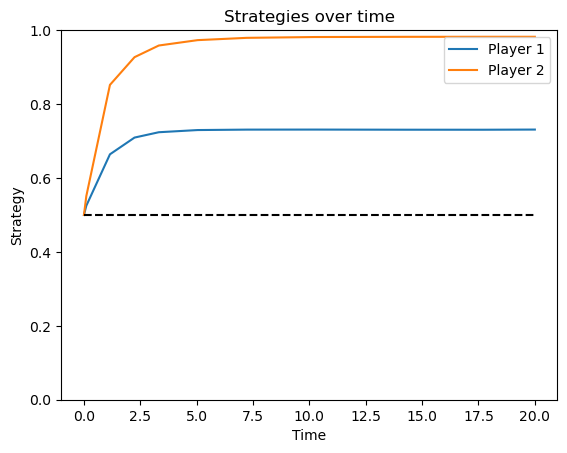

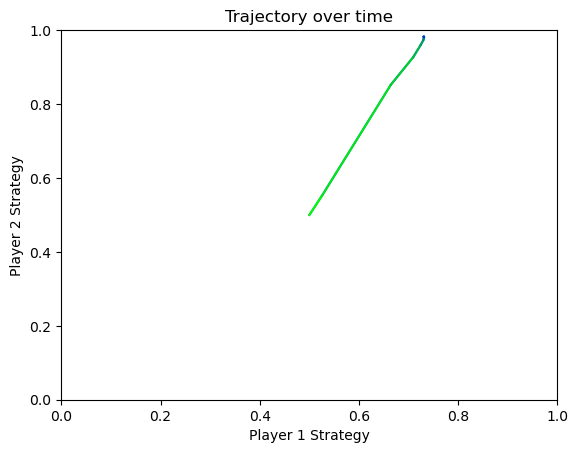

final strategies = [0.73094343 0.98200532]


In [25]:
# dot(x) = x(1-x)(r_1-r_2-T*ln(x)(1-x))

# so need functionf for r_1, r_2, and different T_x, T_y. 

def make_equations(r_1, r_2, T_x, T_y): # might remake the system each time     
    threshold = 0.001 # to make sure the dyanmics stay in [t, 1-t], so we don't get a domain error with the logarithm. 
    
    def ODE_system(t,X): # Have to do the evaluation in here, where x is defined. 
        x = X[0]
        y = X[1]
        r_1s = r_1(x,y) # rewards to [x, y] when each chooses the first action (and the other doesn't change their strategy)
        r_2s = r_2(x,y) # same, now with the second action
        L = [0, 0]
        
        if x > threshold and x < 1-threshold:
            L[0] = x*(1-x)*(r_1s[0]-r_2s[0]-T_x(t)*math.log(x/(1-x)))
        if y > threshold and y < 1-threshold:
            L[1] = y*(1-y)*(r_1s[1]-r_2s[1]-T_y(t)*math.log(y/(1-y)))
            
        return L
    return ODE_system
# can make T_x, T_y a function of time t as well. This complicates the printing though, 

def plot_coordinates(ts, ys, title):
    for i in range(len(ys)):
        plt.plot(ts, ys[i])
    plt.plot(ts, [0.5]*len(ts), 'k--')
    plt.legend(["Player 1", "Player 2"]) # or could pass in T_x, T_y.
    plt.title(title)
    plt.ylim([0,1])
    plt.xlabel("Time")
    plt.ylabel("Strategy")
    plt.show()

def plot_trajectory(ts, ys, title):
    plt.plot(ys[0], ys[1])
    xs = ys[0]
    ys = ys[1]
    for i in range(len(ys)-1):
        #plt.plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], color=(i/len(ts),(1-i/len(ts)),0)) # color code by time? How to add a color bar?
        plt.plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], color=(0,(1-i/len(ts)),i/len(ts))) # color code by time? How to add a color bar?
        #plt.plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], color=((1-i/len(ts)),0,i/len(ts))) # color code by time? How to add a color bar?
    plt.title(title) # can include T_x, T_y, or other parameters
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("Player 1 Strategy")
    plt.ylabel("Player 2 Strategy")
    plt.show()
# overlay on vector field? or store the results of several trajectories to overlay?


r_1 = lambda x, y: [2, 2] # the rewards to players 1, 2 when their strategies are x, y. 
r_2 = lambda x, y: [1, 0]
T_x = lambda t: 1
T_y = lambda t: 0.5

#T_y = lambda t: 3*(1-(t/22)**2) # can't be 1-t/t_sol, because then one becomes zero or one, which makes log(0/(1-0)) or log(1/0) undefined.  
#T_y = lambda t: 20-t
#print("[T_x, T_y] = " + str([T_x, T_y]))

ODE_system = make_equations(r_1, r_2, T_x, T_y)

t_sol = 20 # how low to solve the system for. 
x_init = [0.5, 0.5] # because start uniformed, with q-values equal. 
# Alternatively, could set equal to the previous equilibrium (so instead of resetting for each interaction, it's assumed they've learned completely, maybe an offset to the 
# T_x(t) function, then could simulate learning for various periods of time, so well defined?

start = time.time()
res = solve_ivp(ODE_system, (0, t_sol), x_init) # can also change t_eval so it's smoother. 
print("Solving took " + str(time.time()-start) + "\n")


plot_coordinates(res.t,res.y, "Strategies over time")
#plot_trajectory(res.t,res.y, "Trajectory over time, [T_x, T_y] = " + str([T_x, T_y]))
plot_trajectory(res.t,res.y, "Trajectory over time")

print("final strategies = " + str(res.y.T[-1]))

# can add a plot for the temperature over time. 

[[0, 5], [5, 0]]
Solving took 0.007919073104858398



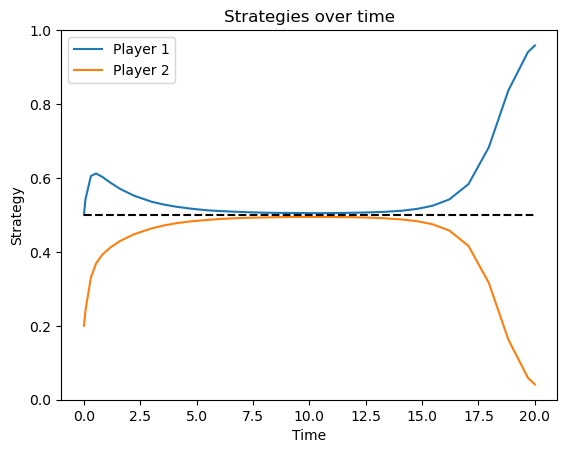

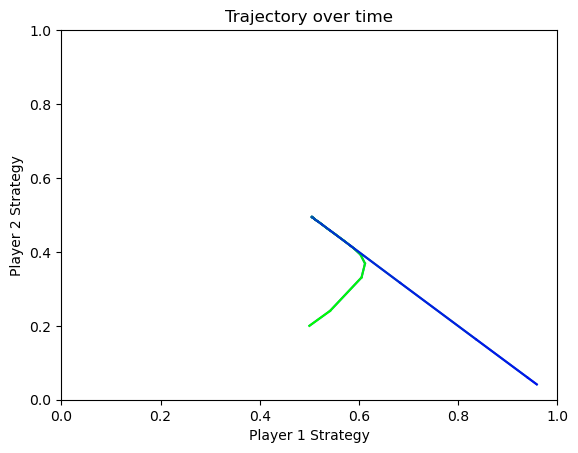

final strategies = [0.95841765 0.04149422]


In [26]:
# Basic 2x2 game check

# Could do three player games and plot in the unit cube (if each strategy is still just mixed between 0 and 1
game = [[0, 5], [5, 0]] # anti-coordination # doesn't seem right, shows them learning the mixed strategy. 
print(game)

r_1 = lambda x, y: [y*game[0][0] + (1-y)*game[0][1], x*game[0][0] + (1-x)*game[0][1]] # the rewards to players 1, 2 when their strategies are x, y. 
r_2 = lambda x, y: [y*game[1][0] + (1-y)*game[1][1], x*game[1][0] + (1-x)*game[1][1]] 

T_x = lambda t: 3*(1-(t/25)**2)
T_y = lambda t: 3*(1-(t/25)**2)

ODE_system = make_equations(r_1, r_2, T_x, T_y)

t_sol = 20 # how low to solve the system for. 
x_init = [0.5, 0.2]

start = time.time()
res = solve_ivp(ODE_system, (0, t_sol), x_init) # can also change t_eval so it's smoother. 
print("Solving took " + str(time.time()-start) + "\n")


plot_coordinates(res.t,res.y, "Strategies over time")
plot_trajectory(res.t,res.y, "Trajectory over time")

print("final strategies = " + str(res.y.T[-1]))

Now we apply this to the Public Goods Game

In [27]:
def helper(n, L): # recursively get them all, by adding the first weight to each, or not. 
    if n == 0:
        return L
        
    new_L = [0]*2*len(L)
    for i in range(len(L)):
        new_L[2*i] = L[i] + [0]
        new_L[2*i+1] = L[i]+[1]
    return helper(n-1, new_L)

def all_binary(n): # returns a list of lists, for each binary string of length n, e.g. [[0, 0], [0, 1], [1, 0], [1, 1]]
    L = helper(n, [[]])
    return L

#print(all_binary(4))

def PGG_payoffs(strats, rewards): # strats is an ordered list of each player's probability of contribution, rewards is a list of the per-individual payoff
    #per number of people who contribute. Can also make a variant where it's a set function. 
    n = len(strats)
    B = all_binary(n) # all possible configurations of who contributes
    
    payoffs = [0]*n
    for i in range(len(B)):
        r = rewards[sum(B[i])]
        p = np.prod([strats[j]**B[i][j] for j in range(n)]) # the product of all the terms in strat where B[i] = 1. 
        p = p*np.prod([(1-strats[j])**(1-B[i][j]) for j in range(n)]) # and now (1-strats[j]) for each B[i][j] = 0
        for j in range(n):
            payoffs[j] += p*(r - B[i][j]) # the reward per, for all, minus whether they contributed or not. # versus, +1 to all, if default is contrib
    return payoffs

#print(PGG_payoffs([0.5, 0.5], [1, 2, 100]))
# with this alone, we could make a heatmap for Adaptive Dynamics of the strategy
# ideally this will be different than the learning dynamics (but those are on the temperature space)

def invasion_payoffs(strats, rewards, n):
    payoffs = PGG_payoffs([strats[0]]+(n-1)*[strats[1]], rewards)
    return payoffs[:3]

#print(invasion_payoffs([0, 1], [0, 1, 2], 2))


def PGG_C(strats, rewards, i):
    strats[i] = 1 # payoff if i always cooperates
    return PGG_payoffs(strats, rewards)

def PGG_D(strats, rewards, i):
    strats[i] = 0 # payoff if i always cooperates
    return PGG_payoffs(strats, rewards)

def PPG_R1(rewards, n): # when action 1 is chosen, CONVENTION? Since x = probability of contribution = x0+(1-x)1, I guess 1 should be C, 2 is D. 
    return lambda x, y: [PGG_C([x]+[y]*(n-1), rewards, 0)[0], PGG_C([x]+[y]*(n-1), rewards, 1)[1]] # the payoff if the first, or second, player chooses to cooperate
def PPG_R2(rewards, n): # when action 2 is chosen, CONVENTION? Since x = probability of contribution = x0+(1-x)1, I guess 1 should be C, 2 is D. 
    return lambda x, y: [PGG_D([x]+[y]*(n-1), rewards, 0)[0], PGG_D([x]+[y]*(n-1), rewards, 1)[1]] # the payoff if the first, or second, player chooses to cooperate

# Very likely not the most efficient way to do this. But probably good enough. 

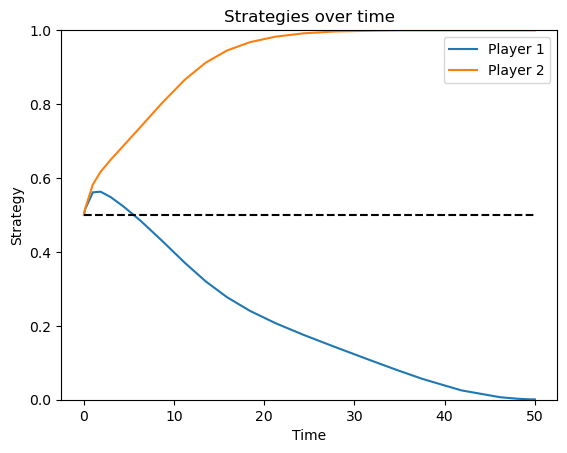

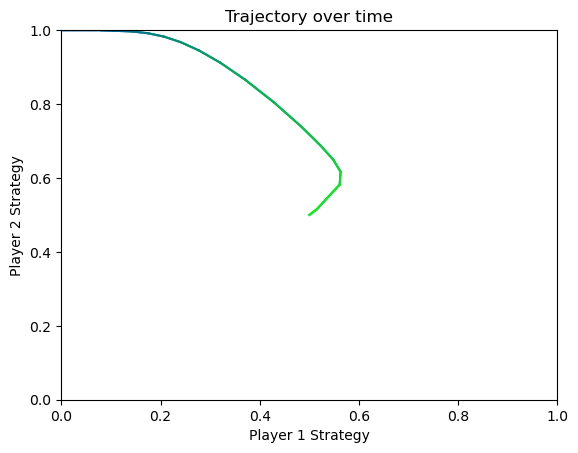

In [29]:
def rewards_from_funct(f, n):
    rewards = [0]*(n+1)
    for i in range(n):
        rewards[i] = f(i/n)
    return rewards # to make compatible with function based (fraction of contributors)

def run_model(rewards, n, t_sol, T_x, T_y):
    r_1 = PPG_R1(rewards, n)
    r_2 = PPG_R2(rewards, n)
    ODE_system = make_equations(r_1, r_2, T_x, T_y)
    x_init = [0.5, 0.5]
    res = solve_ivp(ODE_system, (0, t_sol), x_init) # can also change t_eval so it's smoother.     
    return [invasion_payoffs(res.y.T[-1], rewards, n), res.t, res.y] # so can plot it too


rewards = [1, 4, 4.1]
n = 2 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 50 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
T_x = lambda t: 1*(1-t/(t_sol+1)) # linear slope from the coefficient at t=0 to 0 at t=t_sol (+1 to avoid ln being undefined, really max(this, 0) to solve this). 
T_y = lambda t: 0.5*(1-t/(t_sol+1))

[payoffs, ts, ys] = run_model(rewards, n, t_sol, T_x, T_y)

plot_coordinates(ts, ys, "Strategies over time")
plot_trajectory(ts, ys, "Trajectory over time")

In this case, both intially learn to contribute, as when the other player has strategy around 0.5, it is beneficial to contribute more. However, soon the faster learning player is contributing enough that the average reward for the slower learning player is better through defection, leading them to follow strategy 0 (probability of contribution). 

This code is also compatible with time-varying temperatures as well. Periodic temperature functions enter limit cycles in the strategy space. 

Of particular interest is when the periods do not have a common multiple, that is their ratio is irrational. Then a limit cycle is never reached. For a particular reward function, we see agents trading off who is cooperative and who is the free-rider. This effect wasn't fully investigated as it is mainly driven by the aperiodicity of the pair of temperatures. Nonetheless, it is interesting to see the strategies constrained to a susbet of space. It seems this may be an attractor of the dynamics. 

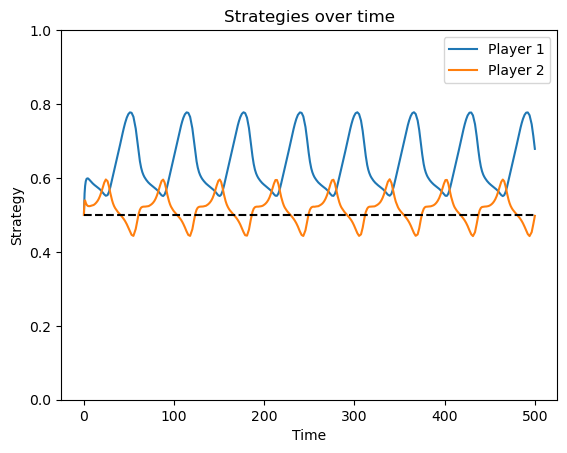

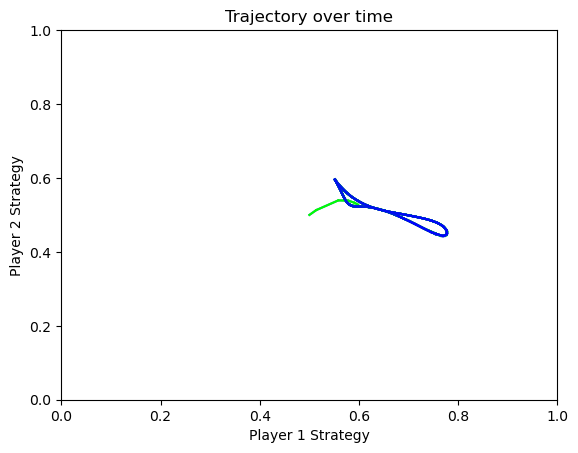

In [34]:
rewards = [1, 4, 4.1]
n = 2 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 500 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
T_x = lambda t: (2+math.sin(t/10))/2 # periodic, so never really zero. 
T_y = lambda t: 2+math.sin(t/5) # faster oscillations

[payoffs, ts, ys] = run_model(rewards, n, t_sol, T_x, T_y)

plot_coordinates(ts, ys, "Strategies over time")
plot_trajectory(ts, ys, "Trajectory over time")

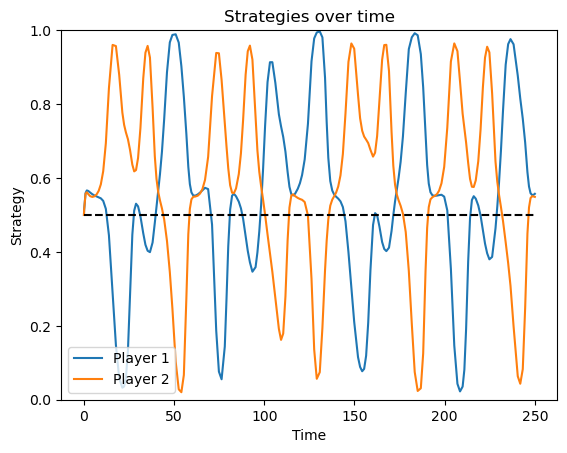

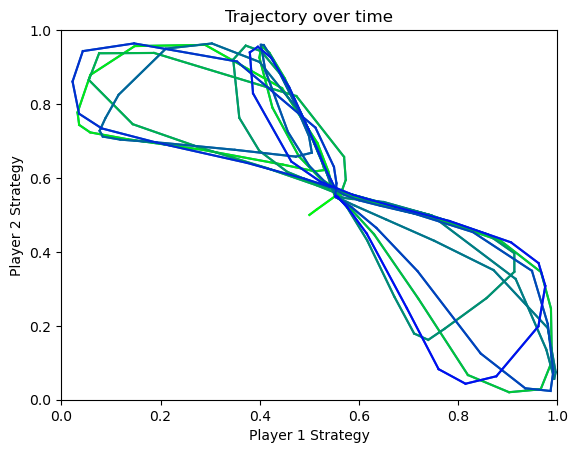

In [40]:
rewards = [1, 4, 4.1]
n = 2 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 250 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
T_x = lambda t: 1+math.sin(t/(3*math.sqrt(2))) # periodic, so never really zero. 
T_y = lambda t: 1+math.sin(t/3) # faster oscillations

[payoffs, ts, ys] = run_model(rewards, n, t_sol, T_x, T_y)

plot_coordinates(ts, ys, "Strategies over time")
plot_trajectory(ts, ys, "Trajectory over time")

## Heatplots

A proxy measure for the fixation probability is known as the invasion fitness. This gives the payoff difference between the mutant and resident strategies when the mutant is rare. This must be positive for the mutant to invade, but being positive is not sufficient. Nonetheless, solving this is much faster and less random, allowing for more robust results. 

The below cells demonstrate the potential for positive and negative selection, as well as attractors. 

Note there can be some issues with the output being too spiky, due to the numerical solutions of the ODE. 

We also found self-payoffs that were non-monotonic in temperature, e.g. for rewards = [1, 1, 1, 4] and vals = [5*i/20 for i in range(20)]

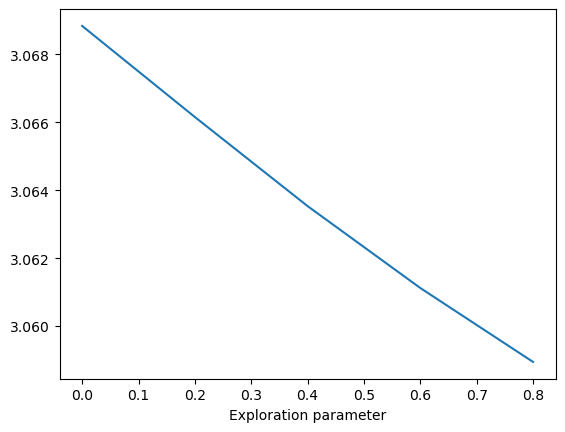

Took 2.2480084896087646


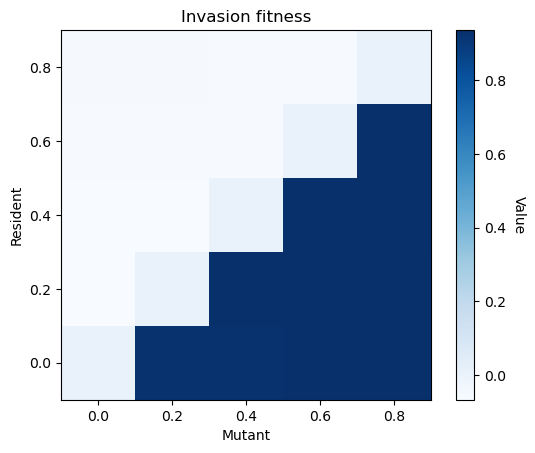

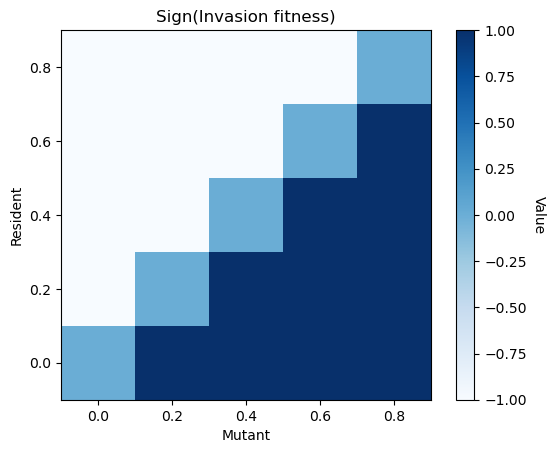

In [30]:
def generate_heatplot(rewards, n, t_sol, plotting, vals, T_funct):
    xs = vals # because of the symmetry, this should be symmetric? Except if n > 2. 
    ys = vals
    table = [[-1 for j in range(len(xs))] for i in range(len(ys))] # how the orientation works
    sign_table = [[-1 for j in range(len(xs))] for i in range(len(ys))] # how the orientation works
    res_payoffs = [-1]*len(ys)
    
    
    start = time.time()
    for i in range(len(ys)): # find all the payoffs when only the resident is present first, the symmetric case 
        y = ys[i]
        T_y = T_funct(y) # could also take powers of this for concavity, or other things. 
    
        [payoffs, ts, y_results] = run_model(rewards, n, t_sol, T_y, T_y)
        res_payoffs[i] = payoffs[0]
    
    if True: # I always want to see
        plt.plot(vals, res_payoffs)
        plt.xlabel("Exploration parameter")
        plt.show("Payoffs in a symmetric population")
    
    for i in range(len(ys)):
        y = ys[i]
        for j in range(len(xs)):
            x = xs[j]
    
            T_x = T_funct(x) #lambda t: x*(1-t/(t_sol+1)) # linear slope from the coefficient at t=0 to 0 at t=t_sol (+1 to avoid ln being undefined, really max(this, 0) to solve this). 
            T_y = T_funct(y) #lambda t: y*(1-t/(t_sol+1)) # could also take powers of this for concavity, or other things. 
    
            # first (x) is the mutant, second (y) is the resident. 
            [payoffs, ts, y_results] = run_model(rewards, n, t_sol, T_x, T_y) # or change so run_model gives cumulative payoffs, an if test, or pass in run_model
            mut_payoff = payoffs[0]
    
            if plotting:
                print("x = " + str(x))
                print("y = " + str(y))
                plot_coordinates(ts, y_results, "Strategies over time")
                plot_trajectory(ts, y_results, "Trajectory over time")
            
            table[i][j] = mut_payoff-res_payoffs[i]
            if mut_payoff > res_payoffs[i]:
                sign_table[i][j] = 1
            elif mut_payoff < res_payoffs[i]:
                sign_table[i][j] = -1
            else:
                sign_table[i][j] = 0
                
    print("Took " + str(time.time()-start))

    make_heatplot(table, xs, ys, "Mutant", "Resident", "Invasion fitness")
    make_heatplot(sign_table, xs, ys, "Mutant", "Resident", "Sign(Invasion fitness)")



rewards = [1, 4, 4.1]
n = 2 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 50 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
plotting = False
#vals = [1, 2, 3]
vals = [i/5 for i in range(5)]
T_funct = lambda a: lambda t: a*(1-t/(t_sol+1)) # so T_x = T_funct(x), so don't have to retype / worry about only changing in one place

generate_heatplot(rewards, n, t_sol, plotting, vals, T_funct)

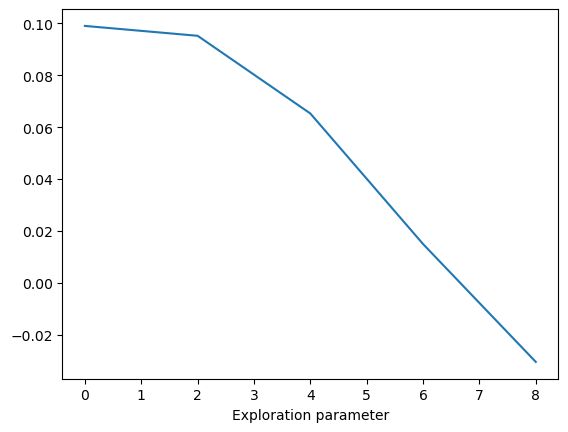

Took 34.43382215499878


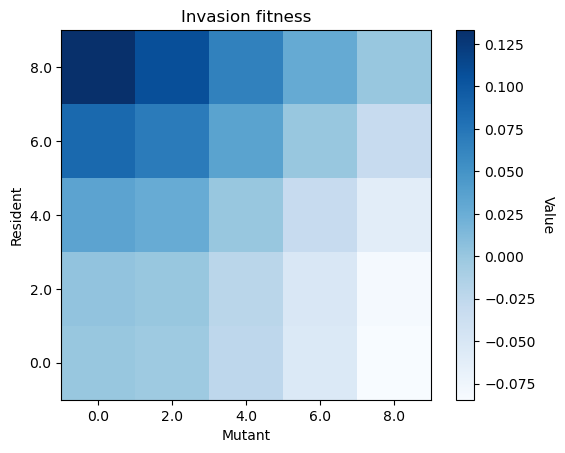

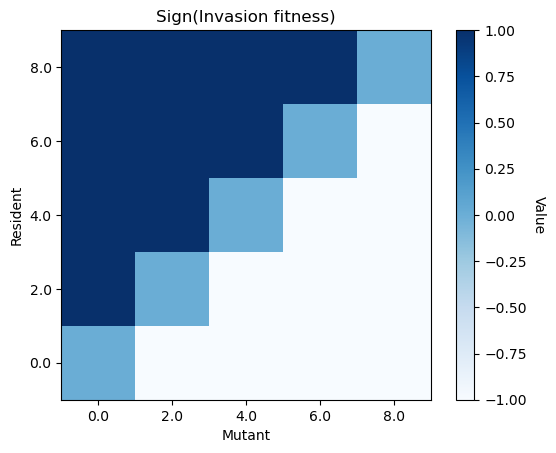

In [31]:
rewards = [0.1, 0.1, 0.1, 1, 1.1, 10.1, 100.1]
n = 5 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 50 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
plotting = False
#vals = [1, 2, 3]
grain = 5
vals = [10*i/grain for i in range(grain)]
T_funct = lambda a: lambda t: a*(1-t/(t_sol+1)) # so T_x = T_funct(x), so don't have to retype / worry about only changing in one place

generate_heatplot(rewards, n, t_sol, plotting, vals, T_funct)

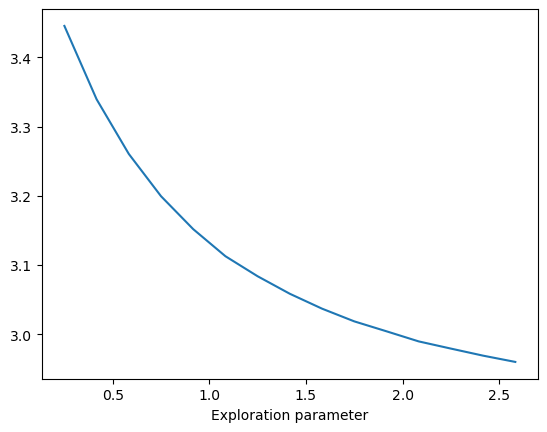

Took 80.04113245010376


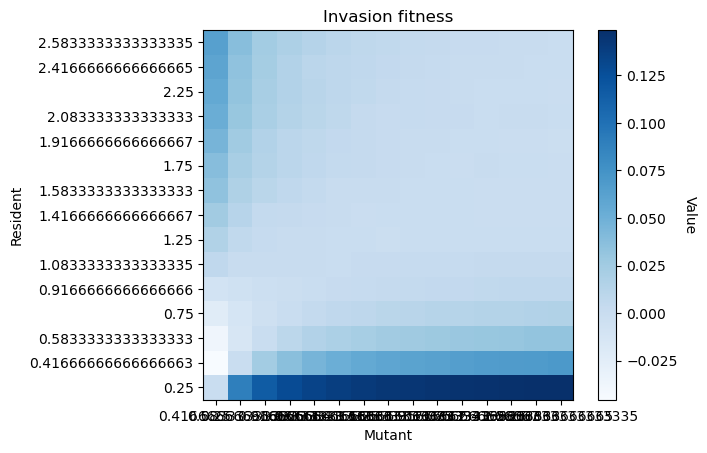

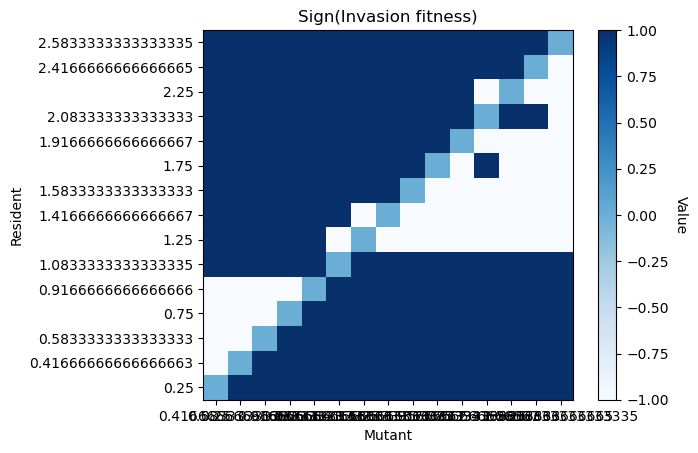

In [17]:
#rewards = [1, 1, 1, 5, 5]
rewards = [1, 1.5, 3.5, 5, 5]
n = 4 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 50 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
plotting = False
#vals = [1, 2, 3]
grain = 15
vals = [0.25+2.5*i/grain for i in range(grain)]
T_funct = lambda a: lambda t: a

# Check that t_sol = 50 is enough to reach equilibrium

generate_heatplot(rewards, n, t_sol, plotting, vals, T_funct)

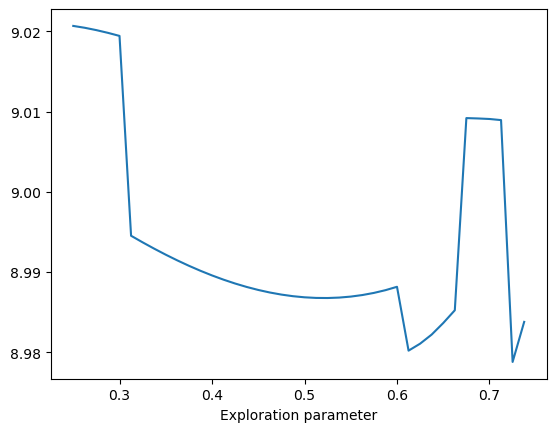

Took 76.48532128334045


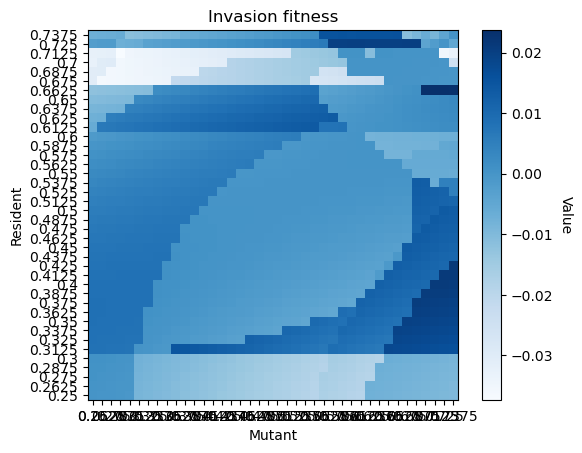

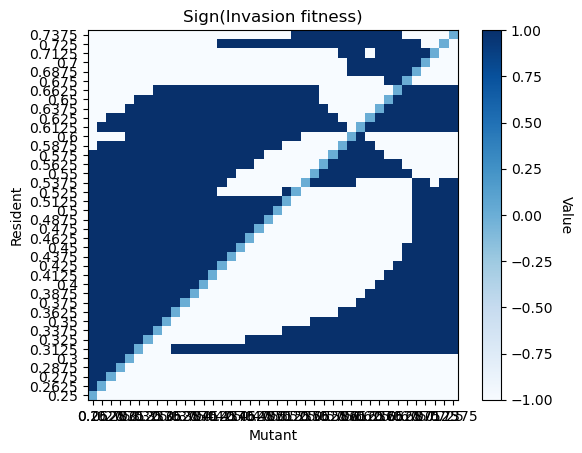

In [148]:
#rewards = [1, 1, 1, 5, 5]
#rewards = [0, 0, 4, 8, 12]
rewards = [0,0, 0, 10]
n = len(rewards)-1 # note, len(rewards) must be n+1 so all possible numbers of contributions have a payoff (0, 1, 2, ..., n), can use rewards_from_funct to see effect of parameters
t_sol = 50 # could also do solve_until_equilibrium, but kind of pointless, since T_x and T_y are chosen to be zero at t_sol, after which no motion will occur. 
plotting = False
#vals = [1, 2, 3]
grain = 40
vals = [0.25+0.5*i/grain for i in range(grain)]
T_funct = lambda a: lambda t: a

# Check that t_sol = 50 is enough to reach equilibrium

generate_heatplot(rewards, n, t_sol, plotting, vals, T_funct)

This is quite perplexing, and is likely due to numerical instability. 

Lastly, we use these values to predict the evolutionary trajectories to determine whether exploration rates will increase or decrease depending on the game parameters. Since the reward functions are a vector, we reduce to the case $[0,x,x+y,m-x-y]$ where only two jumps of $x$ and $y$ occur, in a three player game. This allows us to plot the results in a heatmap as well. 

Amazingly, this gives a simple condition on when mutation rates will evolve upwards! And it's remarkably simple, $j_0 + j_1 = r_2 > s$ where $s$ is some threshold depending on $m$. Note it may not always be the same, as large $m$ are weaker dilemmas. We could plot this versus $m$. 

Note the temperature reached by this is capped by a deadman parameter as some may theoretically evolve towards positive infinity. 

Took 369.29145789146423


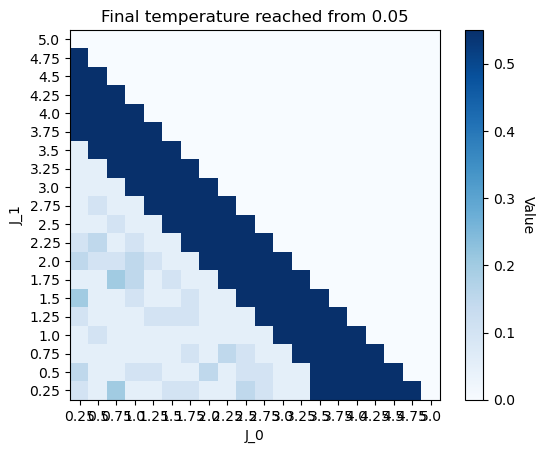

In [156]:
def evolve_temp(base_temp, temp_jump, deadman, n, t_sol, T_funct, rewards): # assumes mutations are +small, tehcnially, might also be able to evolve down too...
    n = len(rewards)-1
    invading = True
    while invading and deadman > 0:
        T_res = T_funct(base_temp) #lambda t: x*(1-t/(t_sol+1)) # linear slope from the coefficient at t=0 to 0 at t=t_sol (+1 to avoid ln being undefined, really max(this, 0) to solve this). 
        T_mut = T_funct(base_temp+temp_jump) #lambda t: y*(1-t/(t_sol+1)) # could also take powers of this for concavity, or other things. 

        [payoffs, ts, y_results] = run_model(rewards, n, t_sol, T_mut, T_res) 
        mut_payoff = payoffs[0]

        [payoffs, ts, y_results] = run_model(rewards, n, t_sol, T_res, T_res) 
        res_payoff = payoffs[0]

        if mut_payoff > res_payoff: # or difference above some threshold, account for numerical issues. 
            base_temp = base_temp + temp_jump
            deadman = deadman-1
        else:
            invading = False
    return base_temp

base_temp = 0.05
temp_jump = 0.05
deadman = 10
n = 3
t_sol = 100
T_funct = lambda a: lambda t: a

m = 5
grain = 20
vals = [(i+1)*m/grain for i in range(grain)]

xs = vals # because of the symmetry, this should be symmetric? Except if n > 2. 
ys = vals
table = [[-1 for j in range(len(xs))] for i in range(len(ys))] # how the orientation works

start = time.time()

for i in range(len(ys)):
    y = ys[i]
    for j in range(len(xs)):
        x = xs[j]

        if x+y > m:
            table[i][j] = 0
        else:
            rewards = [0, x, x+y, m]
            table[i][j] = evolve_temp(base_temp, temp_jump, deadman, n, t_sol, T_funct, rewards)
            
print("Took " + str(time.time()-start))

make_heatplot(table, xs, ys, "J_0", "J_1", "Final temperature reached from " + str(base_temp))

Took 499.61788606643677


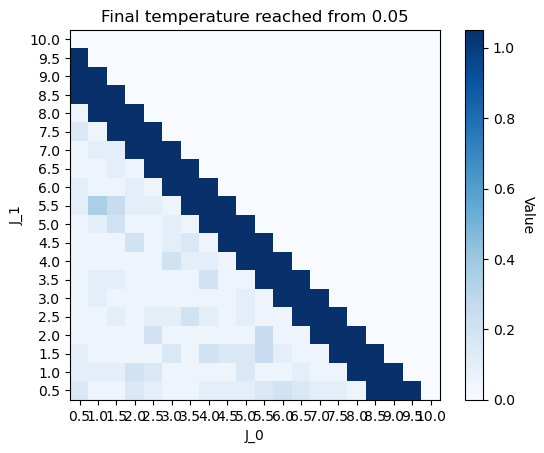

In [158]:
base_temp = 0.05
temp_jump = 0.05
deadman = 20
n = 3
t_sol = 100
T_funct = lambda a: lambda t: a


m = 10
grain = 20
vals = [(i+1)*m/grain for i in range(grain)]



xs = vals # because of the symmetry, this should be symmetric? Except if n > 2. 
ys = vals
table = [[-1 for j in range(len(xs))] for i in range(len(ys))] # how the orientation works

start = time.time()

for i in range(len(ys)):
    y = ys[i]
    for j in range(len(xs)):
        x = xs[j]

        if x+y > m:
            table[i][j] = 0
        else:
            rewards = [0, x, x+y, m]
            table[i][j] = evolve_temp(base_temp, temp_jump, deadman, n, t_sol, T_funct, rewards)
            
print("Took " + str(time.time()-start))

make_heatplot(table, xs, ys, "J_0", "J_1", "Final temperature reached from " + str(base_temp))